# Technical Requirements

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import warnings

plt.rcParams["figure.figsize"] = [14, 7]
warnings.filterwarnings('ignore')

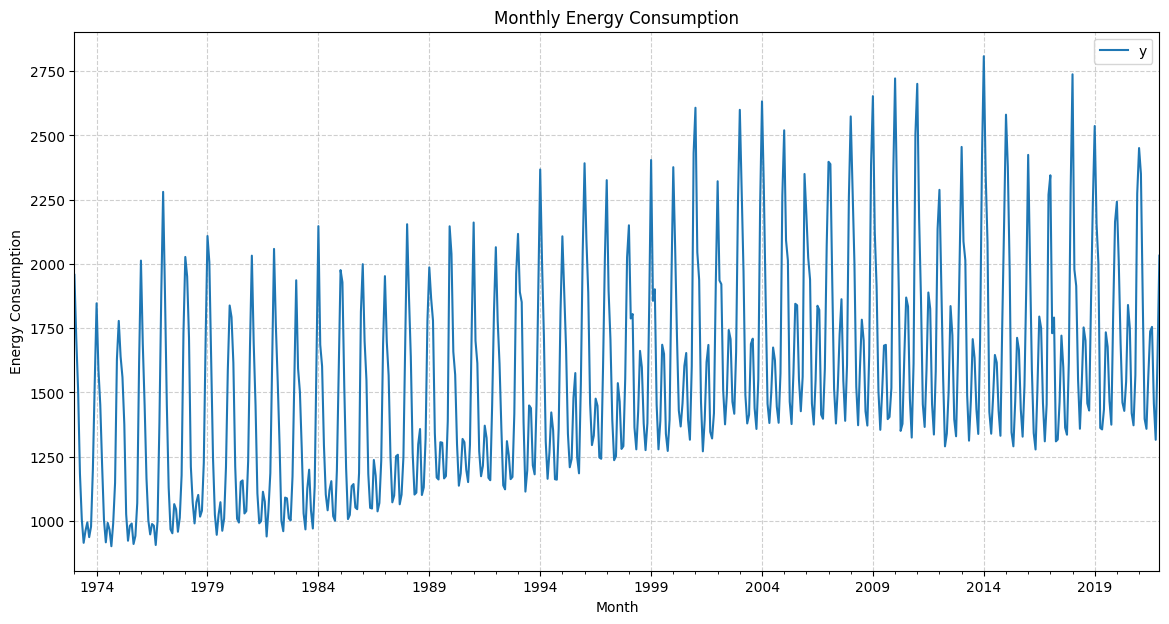

In [2]:
path = Path('../../datasets/Ch13/')
energy = pd.read_csv(path.joinpath('energy_consumption.csv'), 
                     index_col='Month', 
                     parse_dates=True)

energy.columns = ['y'] # rename column for clarity
energy.index.freq = 'MS' #set frequency
energy.plot(title='Monthly Energy Consumption')
plt.xlabel('Month')
plt.ylabel('Energy Consumption')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

In [3]:
print("Original Data Info:")
energy.info()
print(f"\nOriginal Data Head:\n{energy.head()}")

Original Data Info:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 588 entries, 1973-01-01 to 2021-12-01
Freq: MS
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   y       588 non-null    float64
dtypes: float64(1)
memory usage: 9.2 KB

Original Data Head:
                   y
Month               
1973-01-01  1957.641
1973-02-01  1712.143
1973-03-01  1510.079
1973-04-01  1183.421
1973-05-01  1006.326


In [4]:
# --- Preprocessing Functions ---

def fill_missing_forward(df):
    """
    Checks for missing data and fills using forward fill.

    Args:
        df (pd.DataFrame): DataFrame with a time series in a column named 'y'

    Returns:
        pd.DataFrame: DataFrame with missing values filled.
    """
    n_missing = int(df['y'].isna().sum()) # Assuming single column 'y'
    if n_missing > 0:
        print(f'Found {n_missing} missing observations... filling forward.')
        df = df.ffill()
    return df

In [5]:
en_df = fill_missing_forward(energy)

# Forecasting with LSTM

## Using Keras: One-Step Forecasting (Short-Term)

In [6]:
from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import (EarlyStopping, 
                                        ReduceLROnPlateau, 
                                        TensorBoard,
                                        ModelCheckpoint)
from tensorflow.keras.metrics import RootMeanSquaredError, MeanAbsoluteError

In [7]:
# This is added for Reproducibility
import random 
import tensorflow as tf

SEED = 42 
np.random.seed(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)

In [8]:
def create_sequences(df, window_size, target_col='y'):
    """
    Convert a time series into a supervised learning dataset with lagged features.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        Time series data with single target column
    window_size : int
        Number of lagged observations to use as input features
    target_col : str, optional
        Name of the column in 'df' that contains the target time series values.
        Default is 'y'
        
    Returns:
    --------
    pandas.DataFrame
        DataFrame with lagged features (x1, x2, ...) and target (y)
    """
    try:
        # Extract the target column as a 1D NumPy array
        data_values = df[target_col].values 
    except KeyError:
        raise KeyError(f"""Column '{target_col}' not found in DataFrame. 
                        Please ensure the target column is correctly named.""")

    X_list = [data_values[i:i+window_size] for i in range(len(data_values)-window_size)]
    X = np.array(X_list) # Creates a 2D array (num_sequences, window_size)
    
    # Target is the value immediately following each window
    y_values = data_values[window_size:]
    idx = df.index[window_size:]

    feature_cols = [f'x{i+1}' for i in range(window_size)]

    seq_df = pd.DataFrame(X, columns=feature_cols, index=idx)
    # Assign the target values to a column named 'y' in the new DataFrame
    seq_df['y'] = y_values

    return seq_df

In [9]:
en_seq = create_sequences(en_df, 12)
en_seq.head()

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,y
Month,,,,,,,,,,,,,
1974-01-01,1957.641,1712.143,1510.079,1183.421,1006.326,914.949,961.872,994.259,937.083,978.162,1202.105,1538.568,1846.930
1974-02-01,1712.143,1510.079,1183.421,1006.326,914.949,961.872,994.259,937.083,978.162,1202.105,1538.568,1846.930,1589.448
1974-03-01,1510.079,1183.421,1006.326,914.949,961.872,994.259,937.083,978.162,1202.105,1538.568,1846.930,1589.448,1451.073
1974-04-01,1183.421,1006.326,914.949,961.872,994.259,937.083,978.162,1202.105,1538.568,1846.930,1589.448,1451.073,1215.228
1974-05-01,1006.326,914.949,961.872,994.259,937.083,978.162,1202.105,1538.568,1846.930,1589.448,1451.073,1215.228,1003.821


In [10]:
en_seq.shape

(576, 13)

In [11]:
class TimeSeriesStandardScaler:
    """
    Standardizes time series data and provides train/val/test splits.
    """
    def __init__(self, df, test_size, val_size):
        """
        Initializes the preprocessor.

        Args:
            df (pd.DataFrame): The DataFrame containing sequences (features and target).
            test_size (int): Number of periods for the test set.
            val_size (int): Number of periods for the validation set.
        """
        self.data = df
        self.test_periods = test_size
        self.val_periods = val_size
        self.mu = None
        self.sigma = None
    
    def split_data(self):
        """
        Splits the data into training, validation, and test sets based on time order.
        """
        n_total = len(self.data)
        
        test_start = n_total - self.test_periods
        val_start = test_start - self.val_periods
        # Create splits maintaining temporal order
        train = self.data.iloc[:val_start]
        val = self.data.iloc[val_start:test_start]
        test = self.data.iloc[test_start:]
             
        assert len(test) + len(train) + len(val) == len(self.data)
        return train, val, test
    
    def _transform(self, data):
        if self.mu is None or self.sigma is None:
            raise ValueError("Scaler not fitted yet. Call fit_transform() first.")
        data_s = (data - self.mu)/self.sigma
        return data_s
    
    def fit_transform(self):
        """
        Fits the scaler on the training data and transforms train, val, and test sets.
        Scales all features and target using the same parameters derived from the training data.
        """
        train, val, test = self.split_data()
        self.mu, self.sigma = train.mean(), train.std()
        train_scaled = self._transform(train)
        test_scaled = self._transform(test)
        val_scaled = self._transform(val)
        return train_scaled, val_scaled, test_scaled
    
    def inverse_transform(self, data):
        """
        Reverses the standardization transformation.
        """
        return (data * self.sigma)+self.mu
        
    def inverse_transform_target(self, data):
        """
        Reverses standardization for target variable only.
        Assumes target is the last column in the original DataFrame.
        """
        return (data * self.sigma[-1])+self.mu[-1]

In [12]:
scaler = TimeSeriesStandardScaler(en_seq, test_size=12, val_size=36)
k_train_scaled, k_val_scaled, k_test_scaled = scaler.fit_transform()

In [13]:
print(f'''
original: {energy.shape}
sequence_df: {en_seq.shape}
train_scaled: {k_train_scaled.shape}
val_scaled: {k_val_scaled.shape}
test_scaled: {k_test_scaled.shape}
''')


original: (588, 1)
sequence_df: (576, 13)
train_scaled: (528, 13)
val_scaled: (36, 13)
test_scaled: (12, 13)



In [14]:
def prepare_keras_input(*args):
    """
    Converts DataFrames to 3D tensors for LSTM models.
    
    Parameters:
    -----------
    *args : list of pandas.DataFrame
        DataFrames with:
            - Feature columns (x1, x2, ...)
            - Target column 'y'   
    Returns:
    --------
    tuple
        Tuple containing target arrays followed by feature arrays for each input DataFrame
    """
    y = [col.pop('y').values.reshape(-1, 1) for col in args]
    x = [col.values.reshape(*col.shape, 1) for col in args]
    
    return *y, *x

In [15]:
 # For Keras/TensorFlow
(y_train_k, 
 y_val_k, 
 y_test_k, 
 x_train_k, 
 x_val_k, 
 x_test_k) = prepare_keras_input(k_train_scaled.copy(), 
                                  k_val_scaled.copy(), 
                                  k_test_scaled.copy())

In [16]:
print(f"x_train_k shape: {x_train_k.shape}")  
print(f"y_train_k shape: {y_train_k.shape}")  

x_train_k shape: (528, 12, 1)
y_train_k shape: (528, 1)


```python
model = Sequential()
model.add(Input(shape=input_shape))
model.add(LSTM(units=units))
model.add(Dense(1)) 
```

adding Dropout

```python
model = Sequential()
model.add(Input(shape=input_shape))
model.add(LSTM(units=units))
model.add(Dropout(dropout_rate))
model.add(Dense(1)) 
```

adding another LSTM and Dropout layers

```python
model = Sequential()
model.add(Input(shape=input_shape))
model.add(LSTM(units=units, return_sequences=True))
model.add(Dropout(dropout_rate))
model.add(LSTM(units=units//2))  # Second LSTM layer with fewer units
model.add(Dropout(dropout_rate))
model.add(Dense(1))
```

In [17]:
def create_keras_lstm_model(input_shape, units=32, dropout_rate=0.2):
    """
    Creates a stacked Keras LSTM model for time series forecasting.

    Args:
        input_shape (tuple): Shape of the input data (timesteps, features). Example: (WINDOW_SIZE, 1).
        units (int): Number of units in the first LSTM layer.
                     The second LSTM layer will use units//2
        dropout_rate (float): Dropout rate after each LSTM layer.
    Returns:
        keras.Model: Compiled Keras model.
    """
    model = Sequential()
    # Input shape expected by LSTM: (batch_size, timesteps, features)
    # We provide (timesteps, features) via input_shape
    model.add(Input(shape=input_shape))
    model.add(LSTM(units=units, return_sequences=True))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(units=units))  # Second LSTM layer with fewer units
    model.add(Dropout(dropout_rate))
    model.add(Dense(1)) # Output layer for forecasting

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  loss='mean_squared_error',
                  metrics=[RootMeanSquaredError(name='rmse'),
                           MeanAbsoluteError(name='mae')])
    return model


In [18]:
keras_input_shape = (x_train_k.shape[1], x_train_k.shape[2])

keras_lstm_model = create_keras_lstm_model(input_shape=keras_input_shape,
                                     units=32,
                                     dropout_rate=0.2)
keras_lstm_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 12, 32)         │         4,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 12, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,705 (49.63 KB)

 Trainable params: 12,705 (49.63 KB)

 Non-trainable params: 0 (0.00 B)

In [19]:
def train_keras_model(model, x_train, y_train, x_val, y_val,
                      epochs=500, 
                      patience=15,
                      batch_size=32):
    """
    Trains the Keras model with early stopping.

    Args:
        model (keras.Model): The compiled Keras model.
        x_train, y_train: Training data and targets.
        x_val, y_val: Validation data and targets.
        epochs (int): Maximum number of training epochs.
        patience (int): Number of epochs with no improvement to wait before stopping.
        batch_size (int): Training batch size.

    Returns:
        keras.callbacks.History: Training history object.
    """
    print(f"\nTraining Keras model for max {epochs} epochs (patience={patience}, batch_size={batch_size})...")
    early_stopping = EarlyStopping(monitor="val_loss",
                                   patience=patience,
                                   min_delta=0.001, # Small improvement threshold
                                   restore_best_weights=True, # Restore weights from best epoch
                                   verbose=1) 

    # persisting model best weights
    model_checkpoint = ModelCheckpoint(
        filepath='./logs/best_model.keras',
        monitor="val_loss",
        save_best_only=True,
        mode="min",
        verbose=1,
        save_freq="epoch")

    reduce_lr = ReduceLROnPlateau(monitor='val_loss', 
                                  factor=0.2, 
                                  patience=patience//3, 
                                  min_lr=1e-6,
                                  verbose=1)
    
    tensorboard= TensorBoard(log_dir='./logs', 
                             histogram_freq=1)

    history = model.fit(x_train, y_train,
                        shuffle=False, # Important for time series
                        epochs=epochs,
                        batch_size=batch_size,
                        validation_data=(x_val, y_val),
                        callbacks=[early_stopping, 
                                   reduce_lr, 
                                   tensorboard,
                                   model_checkpoint],
                        verbose=1) # Set to 1 or 2 for progress, 0 for silent
    print("Keras training complete.")
    return history

In [20]:
%%time
history_lstm_keras = train_keras_model(
    keras_lstm_model,
    x_train_k, y_train_k,
    x_val_k, y_val_k,
    epochs=500,
    patience=15,
    batch_size=32)


Training Keras model for max 500 epochs (patience=15, batch_size=32)...
Epoch 1/500
12/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.0490 - mae: 0.9039 - rmse: 1.0219
Epoch 1: val_loss improved from None to 0.97812, saving model to ./logs/best_model.keras
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.9953 - mae: 0.8018 - rmse: 0.9976 - val_loss: 0.9781 - val_mae: 0.7380 - val_rmse: 0.9890 - learning_rate: 0.0010
Epoch 2/500
15/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.8243 - mae: 0.8056 - rmse: 0.9074 
Epoch 2: val_loss improved from 0.97812 to 0.76389, saving model to ./logs/best_model.keras
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.8124 - mae: 0.7595 - rmse: 0.9013 - val_loss: 0.7639 - val_mae: 0.6992 - val_rmse: 0.8740 - learning_rate: 0.0010
Epoch 3/500
14/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6869 - mae: 0.7002 - rmse: 0.8281 
Epoch 3: val_loss improved from 0.76389 to 0.63694, saving model to ./logs/best_model.keras
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step -

In [22]:
%load_ext tensorboard
%tensorboard --logdir=./logs

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 91578), started 0:00:28 ago. (Use '!kill 91578' to kill it.)

In [23]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

def plot_forecast(model, x_test, y_test, test_index, history, preprocessor_instance):
    """
    Plots training loss and actual vs forecasted values for Keras model.

    Args:
        model (keras.Model): Trained Keras model.
        x_test (np.ndarray): Scaled test features.
        y_test (np.ndarray): Scaled test target.
        test_index (pd.Index): Datetime index for the test set.
        history (keras.callbacks.History): Training history object.
        preprocessor_instance (TimeSeriesStandardScaler): 
                The fitted preprocessor object used for inverse scaling.
    """
    fig, ax = plt.subplots(2, 1, figsize=(14, 10))

    # Plot 1: Training and Validation Loss
    # Training loss plot
    pd.Series(history.history['loss']).plot(
                       style='k--',
                       alpha=0.50, 
                       title='Keras Model Loss per Epoch',
                       ax = ax[0], 
                       label='Training loss')
    
    # Validation loss plot
    pd.Series(history.history['val_loss']).plot(
                      style='k',
                      ax=ax[0],
                      label='Validation loss')
    ax[0].legend()
    ax[0].grid(True, linestyle='--', alpha=0.5)

    
    # Plot 2: Actual vs Predicted Values
    # Get predictions
    predicted = model.predict(x_test)
    # Inverse transform predictions and actual values to original scale
    predicted_original = preprocessor_instance.inverse_transform_target(predicted)
    y_test_original = preprocessor_instance.inverse_transform_target(y_test)

    # Plot actual values
    pd.Series(y_test_original.reshape(-1), 
              index=test_index).plot(
                                style='k--', 
                                alpha=0.5, 
                                ax=ax[1], 
                                title='Keras LSTM One-Step Forecast vs Actual (Test Set)',
                                label='Actual')
    pd.Series(predicted_original.reshape(-1), 
              index=test_index).plot(
                                style='k',
                                label='Forecast', 
                                ax=ax[1])
    fig.tight_layout()
    ax[1].legend()
    ax[1].grid(True, linestyle='--', alpha=0.5)
    ax[1].set_xlabel('Month')
    ax[1].set_ylabel('Energy Consumption')
    plt.show()

    mae_keras = mean_absolute_error(y_test_original, predicted_original)
    rmse_keras = np.sqrt(mean_squared_error(y_test_original, predicted_original))
    print(f"Keras Test Set MAE:  {mae_keras:.4f}") 
    print(f"Keras Test Set RMSE: {rmse_keras:.4f}") 

In [24]:
history_lstm_keras.history.keys()

dict_keys(['loss', 'mae', 'rmse', 'val_loss', 'val_mae', 'val_rmse', 'learning_rate'])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


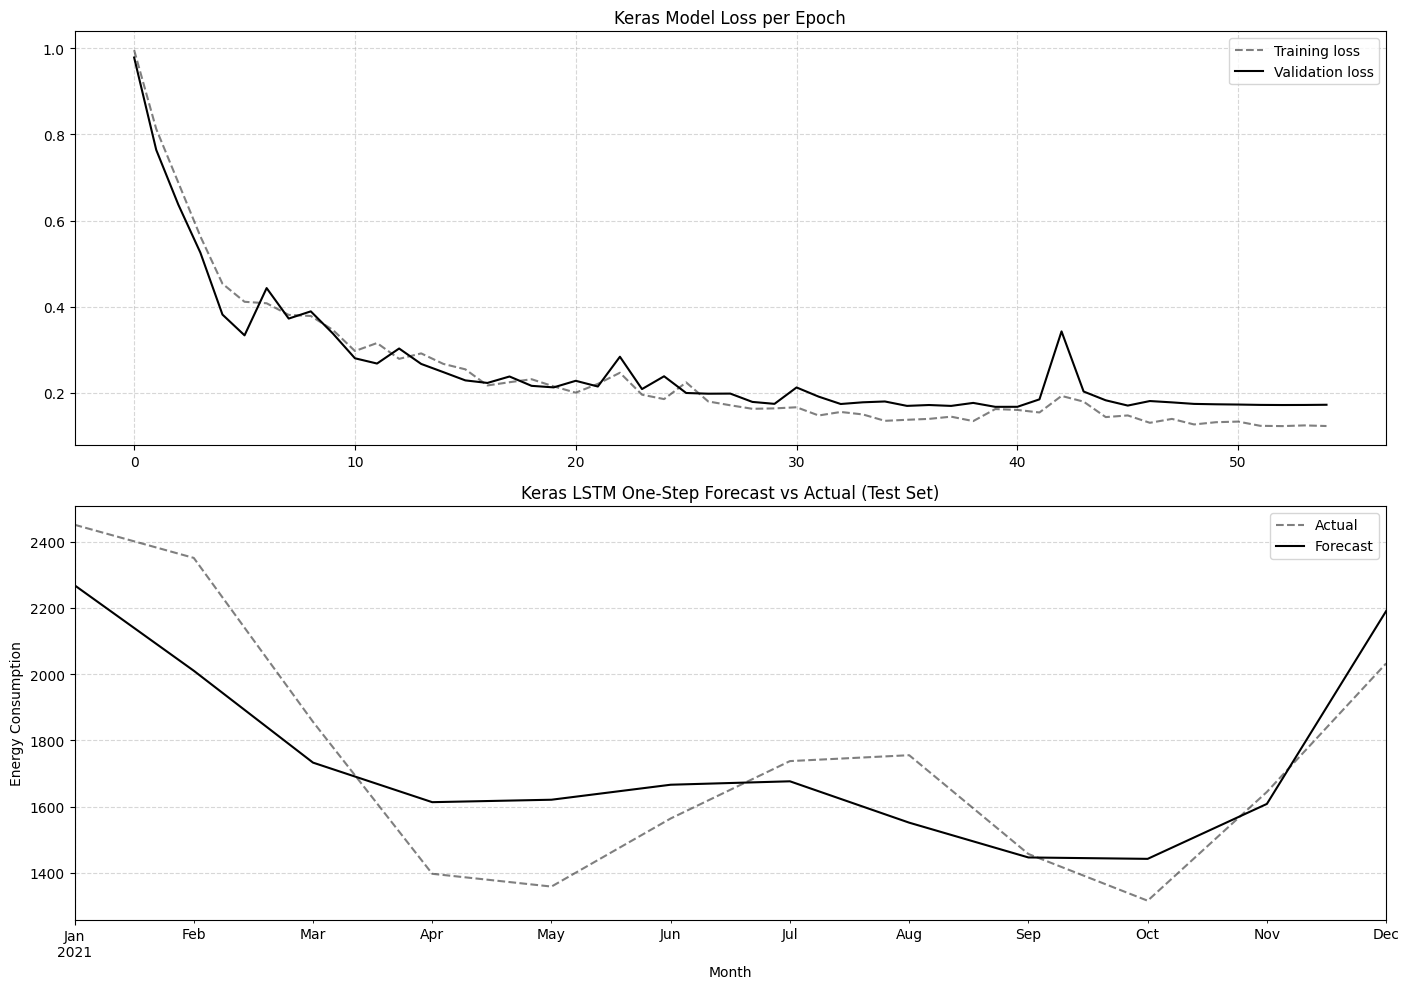

Keras Test Set MAE:  151.8853
Keras Test Set RMSE: 177.5005


In [25]:
plot_forecast(keras_lstm_model, 
              x_test_k, 
              y_test_k, 
              k_test_scaled.index, 
              history_lstm_keras, scaler)

## Using Darts RNNModel for LSTM

In [26]:
import darts
darts.__version__

'0.38.0'

In [27]:
from darts.models import RNNModel
from darts import TimeSeries
from darts.dataprocessing.transformers import Scaler
from darts.metrics import rmse, mae
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping
import torch

The StatsForecast module could not be imported. To enable support for the AutoARIMA, AutoETS and Croston models, please consider installing it.
The `XGBoost` module could not be imported. To enable XGBoost support in Darts, follow the detailed instructions in the installation guide: https://github.com/unit8co/darts/blob/master/INSTALL.md
The `XGBoost` module could not be imported. To enable XGBoost support in Darts, follow the detailed instructions in the installation guide: https://github.com/unit8co/darts/blob/master/INSTALL.md


In [28]:
en_cp = en_df.copy().reset_index()
ts = TimeSeries.from_dataframe(en_cp, 
                               time_col='Month', 
                               value_cols='y', 
                               freq='MS')
ts = ts.astype(np.float32)

In [29]:
n_total = len(ts)
n_test = 12 
n_val = 36 

# Calculate split indices
test_start = n_total - n_test
val_start = test_start - n_val
        
# Create splits maintaining temporal order
d_train = ts[:val_start]
d_val = ts[val_start:test_start]
d_test = ts[test_start:]

print(f'''
train: {len(d_train)}
val : {len(d_val)}
test: {len(d_test)}''')


train: 540
val : 36
test: 12


In [30]:
from sklearn.preprocessing import StandardScaler
d_scaler = Scaler(StandardScaler())

d_train_scaled = d_scaler.fit_transform(d_train)
d_val_scaled = d_scaler.transform(d_val)
d_test_scaled = d_scaler.transform(d_test)
d_series = d_scaler.transform(ts)

In [33]:
# Darts LSTM parameters
darts_lstm_params = {
    'model':'LSTM',            # Specify the RNN type
    'input_chunk_length': 12,  # How many time steps the model sees (your 'window'),
    'training_length': 13,
    'hidden_dim': 32,  # LSTM units
    'n_rnn_layers': 2, # Number of LSTM layers
    'dropout': 0.2,    # Dropout rate
    'batch_size': 32,  # Batch size for training
    'n_epochs': 500,   # Max number of epochs
    'optimizer_kwargs': {'lr': 0.001}, # Adam is default
    'random_state': 42, # For reproducibility
    'force_reset':True  # Ensure fresh model training
}

PATIENCE=15
early_stopper = EarlyStopping(
    monitor="val_loss",  # Darts/PyTorch Lightning default validation loss metric name
    patience=PATIENCE,   # Early stopping patience
    min_delta=0.001,     # Minimum change to qualify as an improvement
    mode='min',          # We want to minimize loss
    verbose=True)

trainer_kwargs = {
    "callbacks": [early_stopper],
    "enable_progress_bar": True, # Show training progress bar
    "accelerator":"auto"}

lr_scheduler_kwargs = {
        "mode": "min",
        "monitor": "val_loss",
        "factor": 0.2,
        "patience": PATIENCE//3, 
        "min_lr": 1e-6,
        # "verbose": True
    }

darts_lstm_model = RNNModel(
    **darts_lstm_params,
    model_name='energy_lstm',
    log_tensorboard=True,       # Set True to use TensorBoard
    save_checkpoints=True,      # Set True to save model checkpoints
    lr_scheduler_cls=torch.optim.lr_scheduler.ReduceLROnPlateau,
    lr_scheduler_kwargs= lr_scheduler_kwargs,
    pl_trainer_kwargs=trainer_kwargs # Pass trainer args including callbacks
)

In [34]:
%%time
darts_lstm_model.fit(d_train_scaled,
                     val_series=d_val_scaled,
                     verbose=True) # verbose=True shows epoch progress

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 12.9 K | train
6 | V               | Linear           | 33     | train
-------------------------------------------------------------
13.0 K    Trainable params
0         Non-trainable params
13.0 K    Total params
0.052     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 17/17 [00:03<00:00,  5.35it/s, v_num=logs, train_loss=0.930, val_loss=0.959]

Metric val_loss improved. New best score: 0.959


Epoch 1: 100%|██████████| 17/17 [00:00<00:00, 121.19it/s, v_num=logs, train_loss=0.881, val_loss=0.943]

Metric val_loss improved by 0.016 >= min_delta = 0.001. New best score: 0.943


Epoch 2: 100%|██████████| 17/17 [00:00<00:00, 113.00it/s, v_num=logs, train_loss=0.587, val_loss=0.858]

Metric val_loss improved by 0.085 >= min_delta = 0.001. New best score: 0.858


Epoch 3: 100%|██████████| 17/17 [00:00<00:00, 118.86it/s, v_num=logs, train_loss=0.374, val_loss=0.720]

Metric val_loss improved by 0.138 >= min_delta = 0.001. New best score: 0.720


Epoch 4: 100%|██████████| 17/17 [00:00<00:00, 112.71it/s, v_num=logs, train_loss=0.364, val_loss=0.593]

Metric val_loss improved by 0.127 >= min_delta = 0.001. New best score: 0.593


Epoch 5: 100%|██████████| 17/17 [00:00<00:00, 119.31it/s, v_num=logs, train_loss=0.413, val_loss=0.578]

Metric val_loss improved by 0.016 >= min_delta = 0.001. New best score: 0.578


Epoch 6: 100%|██████████| 17/17 [00:00<00:00, 123.25it/s, v_num=logs, train_loss=0.280, val_loss=0.565]

Metric val_loss improved by 0.013 >= min_delta = 0.001. New best score: 0.565


Epoch 7: 100%|██████████| 17/17 [00:00<00:00, 124.48it/s, v_num=logs, train_loss=0.334, val_loss=0.551]

Metric val_loss improved by 0.014 >= min_delta = 0.001. New best score: 0.551


Epoch 9: 100%|██████████| 17/17 [00:00<00:00, 105.59it/s, v_num=logs, train_loss=0.302, val_loss=0.541]

Metric val_loss improved by 0.010 >= min_delta = 0.001. New best score: 0.541


Epoch 10: 100%|██████████| 17/17 [00:00<00:00, 121.86it/s, v_num=logs, train_loss=0.263, val_loss=0.516]

Metric val_loss improved by 0.025 >= min_delta = 0.001. New best score: 0.516


Epoch 14: 100%|██████████| 17/17 [00:00<00:00, 127.02it/s, v_num=logs, train_loss=0.217, val_loss=0.514]

Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.514


Epoch 15: 100%|██████████| 17/17 [00:00<00:00, 121.30it/s, v_num=logs, train_loss=0.178, val_loss=0.501]

Metric val_loss improved by 0.013 >= min_delta = 0.001. New best score: 0.501


Epoch 20: 100%|██████████| 17/17 [00:00<00:00, 128.73it/s, v_num=logs, train_loss=0.172, val_loss=0.488]

Metric val_loss improved by 0.013 >= min_delta = 0.001. New best score: 0.488


Epoch 21: 100%|██████████| 17/17 [00:00<00:00, 113.08it/s, v_num=logs, train_loss=0.155, val_loss=0.476]

Metric val_loss improved by 0.012 >= min_delta = 0.001. New best score: 0.476


Epoch 22: 100%|██████████| 17/17 [00:00<00:00, 120.20it/s, v_num=logs, train_loss=0.190, val_loss=0.470]

Metric val_loss improved by 0.006 >= min_delta = 0.001. New best score: 0.470


Epoch 23: 100%|██████████| 17/17 [00:00<00:00, 124.84it/s, v_num=logs, train_loss=0.145, val_loss=0.459]

Metric val_loss improved by 0.011 >= min_delta = 0.001. New best score: 0.459


Epoch 28: 100%|██████████| 17/17 [00:00<00:00, 125.62it/s, v_num=logs, train_loss=0.120, val_loss=0.456]

Metric val_loss improved by 0.003 >= min_delta = 0.001. New best score: 0.456


Epoch 31: 100%|██████████| 17/17 [00:00<00:00, 124.62it/s, v_num=logs, train_loss=0.164, val_loss=0.446]

Metric val_loss improved by 0.010 >= min_delta = 0.001. New best score: 0.446


Epoch 32: 100%|██████████| 17/17 [00:00<00:00, 123.15it/s, v_num=logs, train_loss=0.153, val_loss=0.445]

Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.445


Epoch 33: 100%|██████████| 17/17 [00:00<00:00, 121.60it/s, v_num=logs, train_loss=0.159, val_loss=0.438]

Metric val_loss improved by 0.007 >= min_delta = 0.001. New best score: 0.438


Epoch 34: 100%|██████████| 17/17 [00:00<00:00, 126.43it/s, v_num=logs, train_loss=0.132, val_loss=0.426]

Metric val_loss improved by 0.013 >= min_delta = 0.001. New best score: 0.426


Epoch 35: 100%|██████████| 17/17 [00:00<00:00, 123.89it/s, v_num=logs, train_loss=0.144, val_loss=0.417]

Metric val_loss improved by 0.009 >= min_delta = 0.001. New best score: 0.417


Epoch 37: 100%|██████████| 17/17 [00:00<00:00, 119.33it/s, v_num=logs, train_loss=0.154, val_loss=0.408]

Metric val_loss improved by 0.008 >= min_delta = 0.001. New best score: 0.408


Epoch 41: 100%|██████████| 17/17 [00:00<00:00, 123.99it/s, v_num=logs, train_loss=0.121, val_loss=0.389] 

Metric val_loss improved by 0.019 >= min_delta = 0.001. New best score: 0.389


Epoch 42: 100%|██████████| 17/17 [00:00<00:00, 123.54it/s, v_num=logs, train_loss=0.125, val_loss=0.378]

Metric val_loss improved by 0.012 >= min_delta = 0.001. New best score: 0.378


Epoch 45: 100%|██████████| 17/17 [00:00<00:00, 126.79it/s, v_num=logs, train_loss=0.165, val_loss=0.370]

Metric val_loss improved by 0.008 >= min_delta = 0.001. New best score: 0.370


Epoch 48: 100%|██████████| 17/17 [00:00<00:00, 123.90it/s, v_num=logs, train_loss=0.156, val_loss=0.358]

Metric val_loss improved by 0.011 >= min_delta = 0.001. New best score: 0.358


Epoch 50: 100%|██████████| 17/17 [00:00<00:00, 128.41it/s, v_num=logs, train_loss=0.114, val_loss=0.344]

Metric val_loss improved by 0.014 >= min_delta = 0.001. New best score: 0.344


Epoch 55: 100%|██████████| 17/17 [00:00<00:00, 117.03it/s, v_num=logs, train_loss=0.137, val_loss=0.318]

Metric val_loss improved by 0.026 >= min_delta = 0.001. New best score: 0.318


Epoch 61: 100%|██████████| 17/17 [00:00<00:00, 125.17it/s, v_num=logs, train_loss=0.122, val_loss=0.305] 

Metric val_loss improved by 0.013 >= min_delta = 0.001. New best score: 0.305


Epoch 62: 100%|██████████| 17/17 [00:00<00:00, 124.39it/s, v_num=logs, train_loss=0.123, val_loss=0.301] 

Metric val_loss improved by 0.004 >= min_delta = 0.001. New best score: 0.301


Epoch 63: 100%|██████████| 17/17 [00:00<00:00, 124.70it/s, v_num=logs, train_loss=0.134, val_loss=0.293] 

Metric val_loss improved by 0.008 >= min_delta = 0.001. New best score: 0.293


Epoch 68: 100%|██████████| 17/17 [00:00<00:00, 121.72it/s, v_num=logs, train_loss=0.136, val_loss=0.284] 

Metric val_loss improved by 0.009 >= min_delta = 0.001. New best score: 0.284


Epoch 69: 100%|██████████| 17/17 [00:00<00:00, 127.19it/s, v_num=logs, train_loss=0.116, val_loss=0.281]

Metric val_loss improved by 0.003 >= min_delta = 0.001. New best score: 0.281


Epoch 72: 100%|██████████| 17/17 [00:00<00:00, 128.71it/s, v_num=logs, train_loss=0.108, val_loss=0.268] 

Metric val_loss improved by 0.013 >= min_delta = 0.001. New best score: 0.268


Epoch 75: 100%|██████████| 17/17 [00:00<00:00, 122.97it/s, v_num=logs, train_loss=0.127, val_loss=0.258] 

Metric val_loss improved by 0.010 >= min_delta = 0.001. New best score: 0.258


Epoch 78: 100%|██████████| 17/17 [00:00<00:00, 125.39it/s, v_num=logs, train_loss=0.097, val_loss=0.252] 

Metric val_loss improved by 0.006 >= min_delta = 0.001. New best score: 0.252


Epoch 79: 100%|██████████| 17/17 [00:00<00:00, 120.63it/s, v_num=logs, train_loss=0.125, val_loss=0.241] 

Metric val_loss improved by 0.011 >= min_delta = 0.001. New best score: 0.241


Epoch 85: 100%|██████████| 17/17 [00:00<00:00, 126.00it/s, v_num=logs, train_loss=0.104, val_loss=0.236] 

Metric val_loss improved by 0.004 >= min_delta = 0.001. New best score: 0.236


Epoch 89: 100%|██████████| 17/17 [00:00<00:00, 119.08it/s, v_num=logs, train_loss=0.0835, val_loss=0.231]

Metric val_loss improved by 0.005 >= min_delta = 0.001. New best score: 0.231


Epoch 90: 100%|██████████| 17/17 [00:00<00:00, 123.91it/s, v_num=logs, train_loss=0.127, val_loss=0.226] 

Metric val_loss improved by 0.005 >= min_delta = 0.001. New best score: 0.226


Epoch 93: 100%|██████████| 17/17 [00:00<00:00, 120.54it/s, v_num=logs, train_loss=0.142, val_loss=0.224]

Metric val_loss improved by 0.003 >= min_delta = 0.001. New best score: 0.224


Epoch 94: 100%|██████████| 17/17 [00:00<00:00, 121.56it/s, v_num=logs, train_loss=0.0908, val_loss=0.222]

Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.222


Epoch 95: 100%|██████████| 17/17 [00:00<00:00, 122.48it/s, v_num=logs, train_loss=0.140, val_loss=0.219] 

Metric val_loss improved by 0.003 >= min_delta = 0.001. New best score: 0.219


Epoch 97: 100%|██████████| 17/17 [00:00<00:00, 112.85it/s, v_num=logs, train_loss=0.113, val_loss=0.218] 

Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.218


Epoch 99: 100%|██████████| 17/17 [00:00<00:00, 123.13it/s, v_num=logs, train_loss=0.0951, val_loss=0.215]

Metric val_loss improved by 0.003 >= min_delta = 0.001. New best score: 0.215


Epoch 101: 100%|██████████| 17/17 [00:00<00:00, 122.42it/s, v_num=logs, train_loss=0.109, val_loss=0.205] 

Metric val_loss improved by 0.010 >= min_delta = 0.001. New best score: 0.205


Epoch 104: 100%|██████████| 17/17 [00:00<00:00, 125.52it/s, v_num=logs, train_loss=0.126, val_loss=0.199] 

Metric val_loss improved by 0.006 >= min_delta = 0.001. New best score: 0.199


Epoch 119: 100%|██████████| 17/17 [00:00<00:00, 119.98it/s, v_num=logs, train_loss=0.100, val_loss=0.204] 

Monitored metric val_loss did not improve in the last 15 records. Best score: 0.199. Signaling Trainer to stop.


Epoch 119: 100%|██████████| 17/17 [00:00<00:00, 108.07it/s, v_num=logs, train_loss=0.100, val_loss=0.204]
CPU times: user 13.7 s, sys: 3.54 s, total: 17.2 s
Wall time: 23.3 s


RNNModel(model=LSTM, hidden_dim=32, n_rnn_layers=2, dropout=0.2, training_length=13, input_chunk_length=12, batch_size=32, n_epochs=500, optimizer_kwargs={'lr': 0.001}, random_state=42, force_reset=True, model_name=energy_lstm, log_tensorboard=True, save_checkpoints=True, lr_scheduler_cls=<class 'torch.optim.lr_scheduler.ReduceLROnPlateau'>, lr_scheduler_kwargs={'mode': 'min', 'monitor': 'val_loss', 'factor': 0.2, 'patience': 5, 'min_lr': 1e-06}, pl_trainer_kwargs={'callbacks': [<pytorch_lightning.callbacks.early_stopping.EarlyStopping object at 0x3359480d0>], 'enable_progress_bar': True, 'accelerator': 'auto'})

In [36]:
%load_ext tensorboard
%tensorboard --logdir=darts_logs/

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6007 (pid 92245), started 0:00:03 ago. (Use '!kill 92245' to kill it.)

In [37]:
best_darts_model = darts_lstm_model.load_from_checkpoint(
                               model_name="energy_lstm", 
                               best=True)
best_darts_model

RNNModel(model=LSTM, hidden_dim=32, n_rnn_layers=2, dropout=0.2, training_length=13, input_chunk_length=12, batch_size=32, n_epochs=500, optimizer_kwargs={'lr': 0.001}, random_state=42, force_reset=True, model_name=energy_lstm, log_tensorboard=True, save_checkpoints=True, lr_scheduler_cls=<class 'torch.optim.lr_scheduler.ReduceLROnPlateau'>, lr_scheduler_kwargs={'mode': 'min', 'monitor': 'val_loss', 'factor': 0.2, 'patience': 5, 'min_lr': 1e-06}, pl_trainer_kwargs={'callbacks': [<pytorch_lightning.callbacks.early_stopping.EarlyStopping object at 0x335948110>], 'enable_progress_bar': True, 'accelerator': 'auto'})

### One-Step Forecast (Similar to Keras)


In [38]:
one_step_forecast_scaled= darts_lstm_model.historical_forecasts(
    series=d_series,
    start=d_test_scaled.start_time(),
    forecast_horizon=1, # We only want one-step-ahead predictions
    stride=1,           # Move one step at a time
    retrain=False,      # Do not retrain the model at each step
    verbose=True
)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  3.00it/s]


In [39]:
one_step_forecast = d_scaler.inverse_transform(one_step_forecast_scaled)

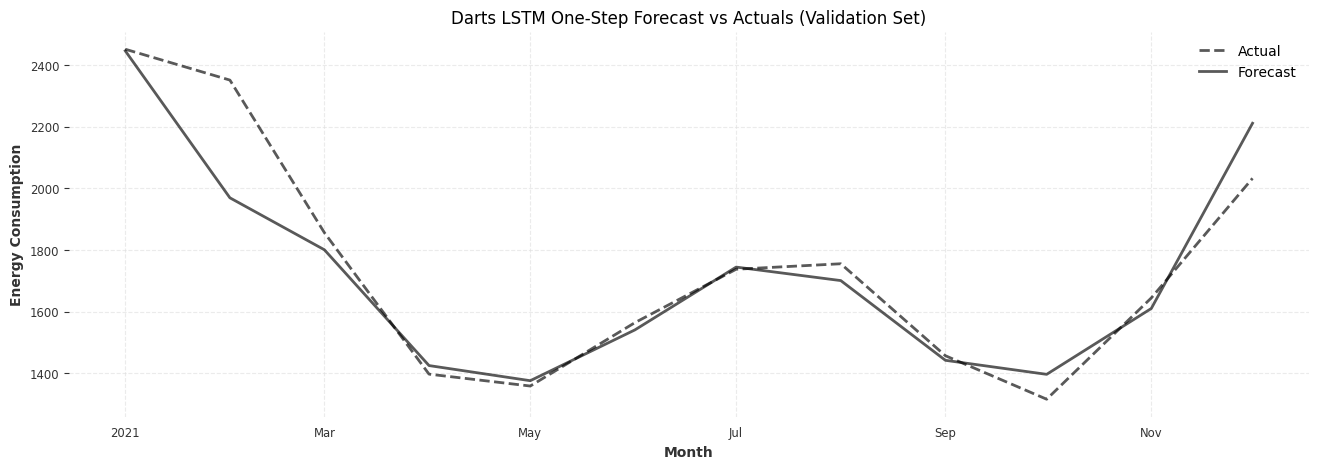

In [40]:
plt.figure(figsize=(16, 5))
d_test.plot(label='Actual', linestyle='--', alpha=0.65) # Plot full historical data
one_step_forecast.plot(label='Forecast', color='k', alpha=0.65)
plt.title('Darts LSTM One-Step Forecast vs Actuals (Validation Set)')
plt.xlabel('Month')
plt.ylabel('Energy Consumption')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

In [41]:
rmse_val = rmse(d_test, one_step_forecast)
mae_val = mae(d_test, one_step_forecast)
print(f"Darts Test Set MAE:  {mae_val:.4f}")
print(f"Darts Test Set RMSE: {rmse_val:.4f}")

Darts Test Set MAE:  73.4404
Darts Test Set RMSE: 126.9493


### Darts Recursive Forecast 

In [42]:
d_train_val_scaled = d_train_scaled.append(d_val_scaled)
preds_scaled = best_darts_model.predict(n=len(d_test), 
                                  series=d_train_val_scaled)

preds_inv = d_scaler.inverse_transform(preds_scaled)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:01<00:00,  0.76it/s]


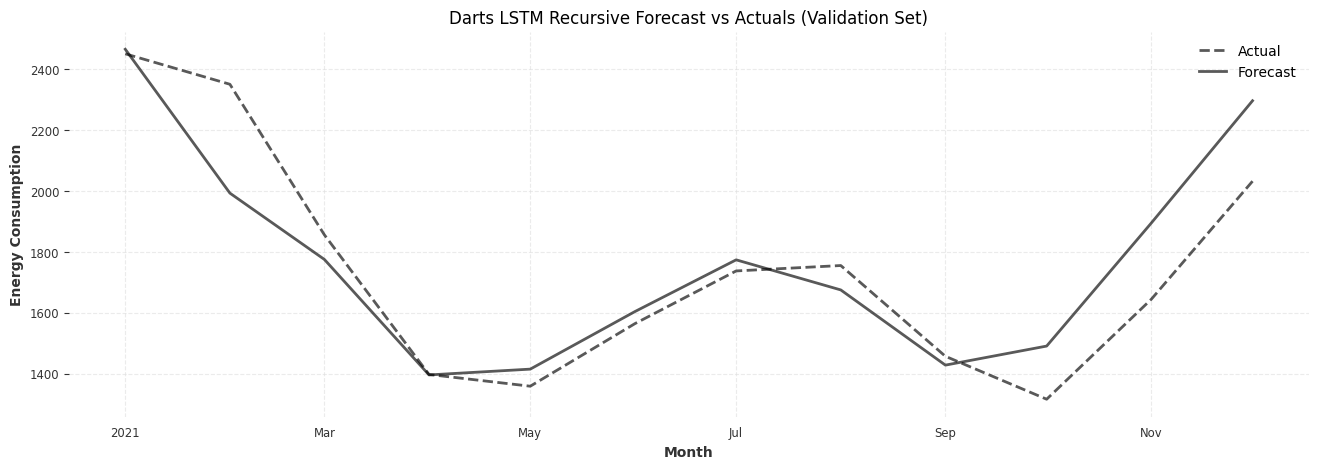

In [43]:
plt.figure(figsize=(16, 5))
d_test.plot(label='Actual', linestyle='--', alpha=0.65) # Plot full historical data
preds_inv.plot(label='Forecast', color='k', alpha=0.65)
plt.title('Darts LSTM Recursive Forecast vs Actuals (Validation Set)')
plt.xlabel('Month')
plt.ylabel('Energy Consumption')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

In [44]:
rmse_val = rmse(d_test, preds_inv)
mae_val = mae(d_test, preds_inv)
print(f"Darts Test Set MAE:  {mae_val:.4f}")
print(f"Darts Test Set RMSE: {rmse_val:.4f}")


Darts Test Set MAE:  115.5418
Darts Test Set RMSE: 161.0847


## Using Darts BlockRNNModel: Long-Term Multioutput

In [55]:
from darts.models import BlockRNNModel

In [56]:
# Darts Block LSTM parameters
darts_blocklstm_params = {
    'model':'LSTM',            # Specify the RNN type
    'input_chunk_length': 24,  # How many time steps the model sees (your 'window')
    'output_chunk_length': 12,  # How many steps the model predicts forward at a time
    'hidden_dim': 32,  # LSTM units
    'n_rnn_layers': 2, # Number of LSTM layers
    'dropout': 0.2,    # Dropout rate
    'batch_size': 32,  # Batch size for training
    'n_epochs': 500,   # Max number of epochs
    'optimizer_kwargs': {'lr': 0.001}, # Adam is default
    'random_state': 42, # For reproducibility
    'force_reset':True  # Ensure fresh model training
}

PATIENCE=15
early_stopper = EarlyStopping(
    monitor="val_loss",  # Darts/PyTorch Lightning default validation loss metric name
    patience=PATIENCE,   # Early stopping patience
    min_delta=0.001,     # Minimum change to qualify as an improvement
    mode='min',          # We want to minimize loss
    verbose=True)

trainer_kwargs = {
    "callbacks": [early_stopper],
    "enable_progress_bar": True, # Show training progress bar
    "accelerator":"auto"}

lr_scheduler_kwargs = {
        "mode": "min",
        "monitor": "val_loss",
        "factor": 0.2,
        "patience": PATIENCE//3, 
        "min_lr": 1e-6,
        # "verbose": True
    }


In [57]:
darts_blocklstm_model = BlockRNNModel(
    **darts_blocklstm_params,
    model_name='energy_blocklstm',
    # log_tensorboard=True,       # Set True to use TensorBoard
    save_checkpoints=True,      # Set True to save model checkpoints
    lr_scheduler_cls=torch.optim.lr_scheduler.ReduceLROnPlateau,
    lr_scheduler_kwargs= lr_scheduler_kwargs,
    pl_trainer_kwargs=trainer_kwargs # Pass trainer args including callbacks
)

In [58]:
%%time
darts_blocklstm_model.fit(d_train_scaled,
                     val_series=d_val_scaled,
                     verbose=True) # verbose=True shows epoch progress

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 12.9 K | train
6 | fc              | Sequential       | 33     | train
-------------------------------------------------------------
13.0 K    Trainable params
0         Non-trainable params
13.0 K    Total params
0.052     Total estimated model params size (MB)
8         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 16/16 [00:00<00:00, 82.83it/s, train_loss=0.778, val_loss=0.723]

Metric val_loss improved. New best score: 0.723


Epoch 1: 100%|██████████| 16/16 [00:00<00:00, 95.10it/s, train_loss=0.571, val_loss=0.680] 

Metric val_loss improved by 0.044 >= min_delta = 0.001. New best score: 0.680


Epoch 2: 100%|██████████| 16/16 [00:00<00:00, 96.48it/s, train_loss=0.371, val_loss=0.562] 

Metric val_loss improved by 0.118 >= min_delta = 0.001. New best score: 0.562


Epoch 3: 100%|██████████| 16/16 [00:00<00:00, 79.79it/s, train_loss=0.172, val_loss=0.395]

Metric val_loss improved by 0.167 >= min_delta = 0.001. New best score: 0.395


Epoch 4: 100%|██████████| 16/16 [00:00<00:00, 97.22it/s, train_loss=0.168, val_loss=0.308] 

Metric val_loss improved by 0.088 >= min_delta = 0.001. New best score: 0.308


Epoch 5: 100%|██████████| 16/16 [00:00<00:00, 96.18it/s, train_loss=0.164, val_loss=0.272] 

Metric val_loss improved by 0.035 >= min_delta = 0.001. New best score: 0.272


Epoch 6: 100%|██████████| 16/16 [00:00<00:00, 94.91it/s, train_loss=0.127, val_loss=0.255] 

Metric val_loss improved by 0.018 >= min_delta = 0.001. New best score: 0.255


Epoch 7: 100%|██████████| 16/16 [00:00<00:00, 94.04it/s, train_loss=0.173, val_loss=0.238] 

Metric val_loss improved by 0.016 >= min_delta = 0.001. New best score: 0.238


Epoch 8: 100%|██████████| 16/16 [00:00<00:00, 94.49it/s, train_loss=0.173, val_loss=0.232] 

Metric val_loss improved by 0.007 >= min_delta = 0.001. New best score: 0.232


Epoch 9: 100%|██████████| 16/16 [00:00<00:00, 91.47it/s, train_loss=0.131, val_loss=0.225] 

Metric val_loss improved by 0.006 >= min_delta = 0.001. New best score: 0.225


Epoch 10: 100%|██████████| 16/16 [00:00<00:00, 93.59it/s, train_loss=0.139, val_loss=0.218] 

Metric val_loss improved by 0.007 >= min_delta = 0.001. New best score: 0.218


Epoch 11: 100%|██████████| 16/16 [00:00<00:00, 92.54it/s, train_loss=0.120, val_loss=0.216] 

Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.216


Epoch 12: 100%|██████████| 16/16 [00:00<00:00, 91.84it/s, train_loss=0.118, val_loss=0.207] 

Metric val_loss improved by 0.009 >= min_delta = 0.001. New best score: 0.207


Epoch 16: 100%|██████████| 16/16 [00:00<00:00, 96.31it/s, train_loss=0.101, val_loss=0.203]  

Metric val_loss improved by 0.004 >= min_delta = 0.001. New best score: 0.203


Epoch 17: 100%|██████████| 16/16 [00:00<00:00, 94.74it/s, train_loss=0.0991, val_loss=0.196] 

Metric val_loss improved by 0.008 >= min_delta = 0.001. New best score: 0.196


Epoch 19: 100%|██████████| 16/16 [00:00<00:00, 95.11it/s, train_loss=0.0996, val_loss=0.188] 

Metric val_loss improved by 0.007 >= min_delta = 0.001. New best score: 0.188


Epoch 20: 100%|██████████| 16/16 [00:00<00:00, 92.31it/s, train_loss=0.102, val_loss=0.180]  

Metric val_loss improved by 0.009 >= min_delta = 0.001. New best score: 0.180


Epoch 22: 100%|██████████| 16/16 [00:00<00:00, 92.27it/s, train_loss=0.100, val_loss=0.170]  

Metric val_loss improved by 0.010 >= min_delta = 0.001. New best score: 0.170


Epoch 23: 100%|██████████| 16/16 [00:00<00:00, 92.54it/s, train_loss=0.0976, val_loss=0.159] 

Metric val_loss improved by 0.011 >= min_delta = 0.001. New best score: 0.159


Epoch 24: 100%|██████████| 16/16 [00:00<00:00, 92.77it/s, train_loss=0.103, val_loss=0.146]  

Metric val_loss improved by 0.013 >= min_delta = 0.001. New best score: 0.146


Epoch 26: 100%|██████████| 16/16 [00:00<00:00, 94.00it/s, train_loss=0.086, val_loss=0.140]  

Metric val_loss improved by 0.006 >= min_delta = 0.001. New best score: 0.140


Epoch 27: 100%|██████████| 16/16 [00:00<00:00, 92.74it/s, train_loss=0.101, val_loss=0.138]  

Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.138


Epoch 28: 100%|██████████| 16/16 [00:00<00:00, 93.67it/s, train_loss=0.101, val_loss=0.134]  

Metric val_loss improved by 0.004 >= min_delta = 0.001. New best score: 0.134


Epoch 30: 100%|██████████| 16/16 [00:00<00:00, 91.18it/s, train_loss=0.0855, val_loss=0.126] 

Metric val_loss improved by 0.007 >= min_delta = 0.001. New best score: 0.126


Epoch 32: 100%|██████████| 16/16 [00:00<00:00, 86.44it/s, train_loss=0.094, val_loss=0.122]  

Metric val_loss improved by 0.005 >= min_delta = 0.001. New best score: 0.122


Epoch 47: 100%|██████████| 16/16 [00:00<00:00, 92.74it/s, train_loss=0.0632, val_loss=0.123] 

Monitored metric val_loss did not improve in the last 15 records. Best score: 0.122. Signaling Trainer to stop.


Epoch 47: 100%|██████████| 16/16 [00:00<00:00, 85.62it/s, train_loss=0.0632, val_loss=0.123]
CPU times: user 6.02 s, sys: 1.48 s, total: 7.49 s
Wall time: 9.48 s


BlockRNNModel(output_chunk_shift=0, model=LSTM, hidden_dim=32, n_rnn_layers=2, hidden_fc_sizes=None, dropout=0.2, activation=ReLU, use_static_covariates=True, input_chunk_length=24, output_chunk_length=12, batch_size=32, n_epochs=500, optimizer_kwargs={'lr': 0.001}, random_state=42, force_reset=True, model_name=energy_blocklstm, save_checkpoints=True, lr_scheduler_cls=<class 'torch.optim.lr_scheduler.ReduceLROnPlateau'>, lr_scheduler_kwargs={'mode': 'min', 'monitor': 'val_loss', 'factor': 0.2, 'patience': 5, 'min_lr': 1e-06}, pl_trainer_kwargs={'callbacks': [<pytorch_lightning.callbacks.early_stopping.EarlyStopping object at 0x35ea913d0>], 'enable_progress_bar': True, 'accelerator': 'auto'})

In [59]:
best_block_model = darts_blocklstm_model.load_from_checkpoint(
                               model_name="energy_blocklstm", 
                               best=True)

In [60]:
d_train_val_scaled = d_train_scaled.append(d_val_scaled)
block_preds_scaled = best_block_model.predict(n=len(d_test), 
                                  series=d_train_val_scaled)
block_preds_inv = d_scaler.inverse_transform(block_preds_scaled)


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 206.70it/s]


In [61]:
rmse_val = rmse(d_test, block_preds_inv)
mae_val = mae(d_test, block_preds_inv)
print(f"Darts Test Set MAE:  {mae_val:.4f}")
print(f"Darts Test Set RMSE: {rmse_val:.4f}")

Darts Test Set MAE:  137.6819
Darts Test Set RMSE: 183.7500


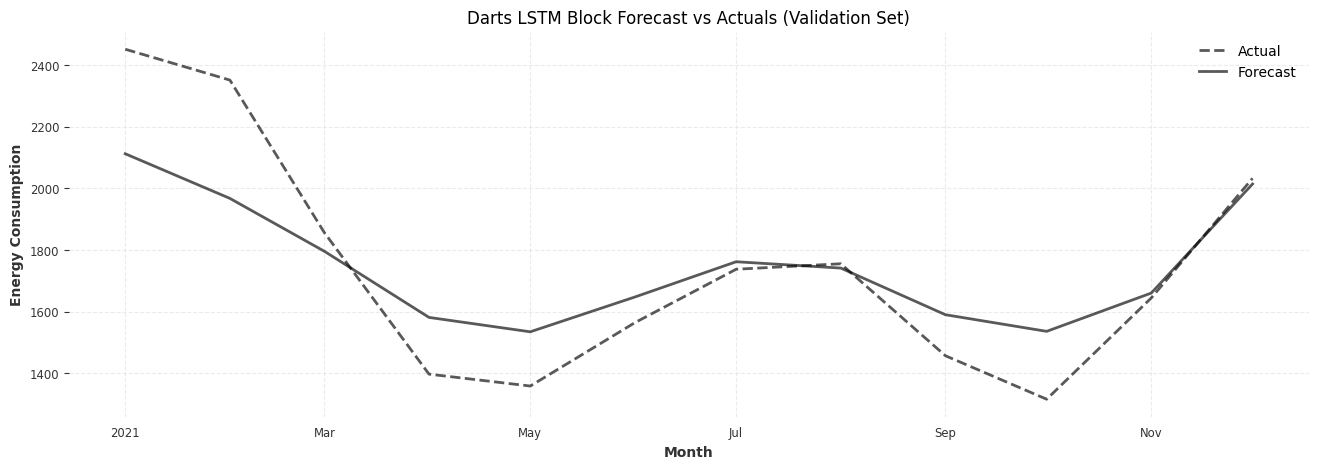

In [62]:
plt.figure(figsize=(16, 5))
d_test.plot(label='Actual', linestyle='--', alpha=0.65) # Plot full historical data
block_preds_inv.plot(label='Forecast', color='k', alpha=0.65)
plt.title('Darts LSTM Block Forecast vs Actuals (Validation Set)')
plt.xlabel('Month')
plt.ylabel('Energy Consumption')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

## NeuralForecast Long-Term Multioutput

In [63]:
from neuralforecast import NeuralForecast
from neuralforecast.models import LSTM as NF_LSTM
from neuralforecast.losses.pytorch import MAE, MSE
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import ModelCheckpoint
from sklearn.metrics import mean_absolute_error, mean_squared_error

logger = TensorBoardLogger("nf_tensorboard_log", name="LSTM")

2025-10-08 21:30:16,298	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2025-10-08 21:30:17,353	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


In [64]:
nf_df = energy.copy().reset_index()
nf_df.rename(columns={'Month': 'ds'}, inplace=True)
nf_df['unique_id'] = 'energy' # Add a unique_id column for NeuralForecast
print(nf_df.head())

          ds         y unique_id
0 1973-01-01  1957.641    energy
1 1973-02-01  1712.143    energy
2 1973-03-01  1510.079    energy
3 1973-04-01  1183.421    energy
4 1973-05-01  1006.326    energy


In [65]:
WINDOW_SIZE = 24 # This is `input_size` in NeuralForecast terms
TEST_LENGTH = 12 # Number of steps to forecast, 'h' in NeuralForecast

train_nf = nf_df.iloc[:-TEST_LENGTH]
test_nf = nf_df.iloc[-TEST_LENGTH:]

print(train_nf.shape)
print(test_nf.shape)

(576, 3)
(12, 3)


In [66]:
# Add checkpoint callback
checkpoint_callback = ModelCheckpoint(
    monitor="valid_loss",
    mode="min",
    save_top_k=1,
)


In [67]:
import math

batch_size = 32
steps_per_epoch = math.ceil(len(train_nf) / batch_size)
steps_per_epoch

18

In [68]:
# NeuralForecast LSTM parameters
PATIENCE = 15
nf_lstm_params = {
    'h': TEST_LENGTH, # Forecast horizon 
    'input_size': WINDOW_SIZE, 
    'encoder_n_layers': 2, # Number of layers for the LSTM 
    'encoder_hidden_size': 32, # Hidden state units 
    'encoder_dropout': 0.2, # Dropout regularization applied to LSTM outputs 
    'max_steps': steps_per_epoch * 500, # to match 500 epochs like Keras and Darts
    'batch_size': batch_size, 
    'learning_rate': 0.001, 
    'num_lr_decays': PATIENCE//3,
    'early_stop_patience_steps': PATIENCE, # Number of validation iterations before early stopping 
    'val_check_steps': steps_per_epoch, # Number of training steps the model evaluates its performance on val set
    'scaler_type': 'standard', # Type of scaler for normalization 
    'random_seed': 42, # For reproducibility
    'logger': logger, # to use with TensorBoard
  #  'decoder_layers':0, # Set to zero to remove the MLP decoder layer.
    'enable_checkpointing': True,
    'recurrent': False, # True = Recursive while False = Direct
    'callbacks': [checkpoint_callback]
}
# Instantiate the NeuralForecast LSTM model
lstm = NF_LSTM(**nf_lstm_params)

Seed set to 42


In [69]:
%%time
# Define the models to be used in NeuralForecast
models = [lstm]

# Create the NeuralForecast object
# The `freq` parameter time series alignment
nf_lstm_model = NeuralForecast(models=models, freq='MS')

# Fit the model. 
#NeuralForecast handles data splitting internally for validation
nf_lstm_model.fit(df=train_nf, val_size= 36) 

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | hist_encoder | LSTM          | 12.9 K | train
4 | mlp_decoder  | MLP           | 4.4 K  | train
-------------------------------------------------------
17.3 K    Trainable params
0         Non-trainable params
17.3 K    Total params
0.069     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode


Epoch 539: 100%|██████████| 1/1 [00:00<00:00, 26.67it/s, v_num=0, train_loss_step=0.211, train_loss_epoch=0.211, valid_loss=88.40]
CPU times: user 7.12 s, sys: 2.16 s, total: 9.28 s
Wall time: 15.5 s


In [71]:
%load_ext tensorboard
%tensorboard --logdir=nf_tensorboard_log/

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6008 (pid 92728), started 0:00:02 ago. (Use '!kill 92728' to kill it.)

In [72]:
# Make predictions. The `predict` method uses the `h` defined in the model.
# It forecasts from the end of the `df` used in `fit`.
nf_forecast = nf_lstm_model.predict()
len(nf_forecast)

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  1.42it/s]


12

In [73]:
nf_forecast.columns

Index(['unique_id', 'ds', 'LSTM'], dtype='object')

In [74]:
# Extract the predictions for our 'energy' unique_id and set the index
nf_forecast_df = nf_forecast[nf_forecast['unique_id'] == 'energy'].set_index('ds')
nf_forecast_df = nf_forecast_df[['LSTM']] # Select the 'LSTM' column, which contains the predictions
nf_forecast_df.head()

,LSTM
ds,
2021-01-01,2264.063965
2021-02-01,2017.535645
2021-03-01,1767.371216
2021-04-01,1536.106567
2021-05-01,1522.890259


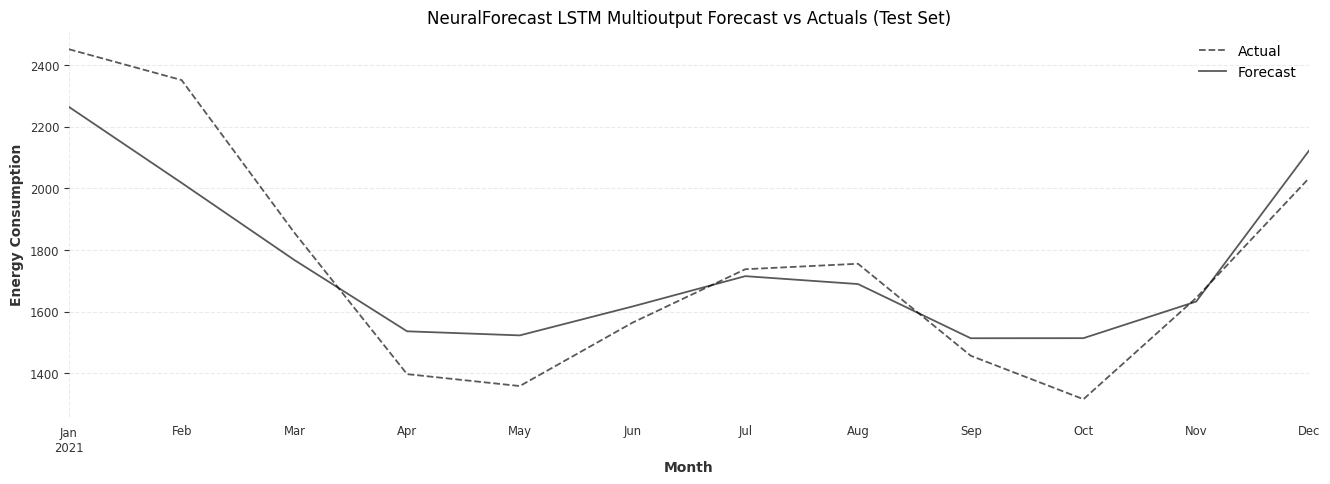

NeuralForecast Test Set MAE:  117.4197
NeuralForecast Test Set RMSE: 146.7713


In [77]:
# Prepare the actual test data for plotting
test_nf.set_index('ds', inplace=True)

plt.figure(figsize=(16, 5))
test_nf['y'].plot(label='Actual', linestyle='--', alpha=0.65)
nf_forecast_df['LSTM'].plot(label='Forecast', color='k', alpha=0.65)
plt.title('NeuralForecast LSTM Multioutput Forecast vs Actuals (Test Set)')
plt.xlabel('Month')
plt.ylabel('Energy Consumption')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# Calculate metrics
mae_nf = mean_absolute_error(test_nf['y'], nf_forecast_df['LSTM'])
rmse_nf = np.sqrt(mean_squared_error(test_nf['y'], nf_forecast_df['LSTM']))

print(f"NeuralForecast Test Set MAE:  {mae_nf:.4f}")
print(f"NeuralForecast Test Set RMSE: {rmse_nf:.4f}")

## There is More

### Keras


In [78]:
# manually loading best weights
keras_lstm_model.load_weights('./logs/best_model.keras')


### Darts 

In [79]:
pred_scaled_lm = darts_lstm_model.predict(n=len(d_test), series=d_train_val_scaled)
pred_inv_lm = d_scaler.inverse_transform(pred_scaled_lm)

rmse_val = rmse(d_test, pred_inv_lm)
mae_val = mae(d_test, pred_inv_lm)
print(f"Darts Test Set MAE:  {mae_val:.4f}")
print(f"Darts Test Set RMSE: {rmse_val:.4f}")

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 131.69it/s]
Darts Test Set MAE:  123.2744
Darts Test Set RMSE: 172.2344


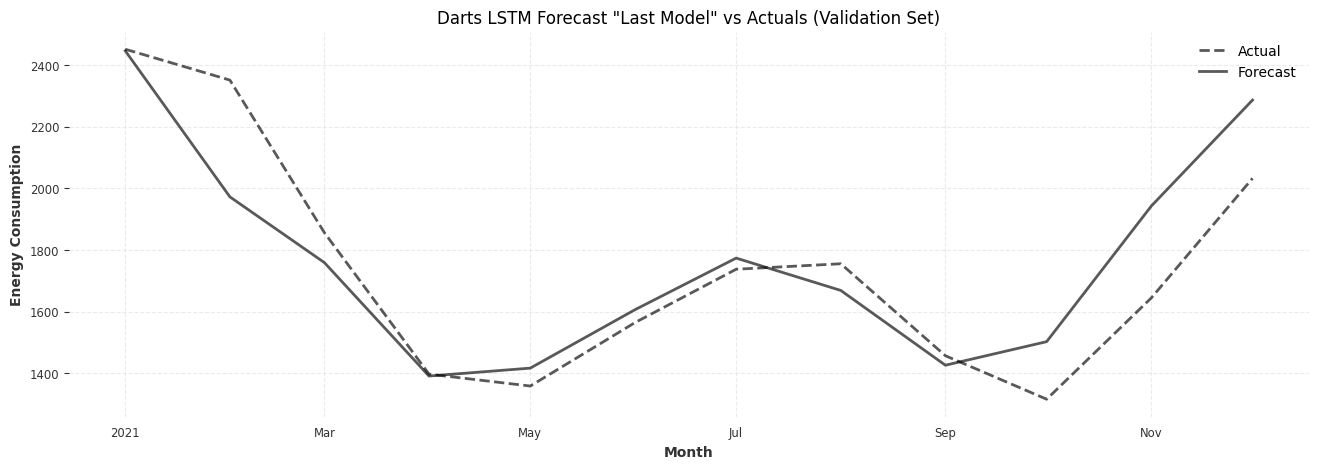

In [80]:
plt.figure(figsize=(16, 5))
d_test.plot(label='Actual', linestyle='--', alpha=0.65) # Plot full historical data
pred_inv_lm.plot(label='Forecast', color='k', alpha=0.65)
plt.title('Darts LSTM Forecast "Last Model" vs Actuals (Validation Set)')
plt.xlabel('Month')
plt.ylabel('Energy Consumption')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

### NeuralForecast: Loading Best Model

In [81]:
# Rebuild parameters with early stopping disabled
reload_params = nf_lstm_params.copy()
reload_params.update({
    'max_steps': 0,                  # Prevent training
    'early_stop_patience_steps': -1, # Disable NeuralForecast's auto EarlyStopping
})
reload_params.pop('callbacks', None) # Remove any callback references

In [82]:
checkpoint_path = 'nf_tensorboard_log/LSTM/version_0/checkpoints/epoch=269-step=270.ckpt'
nf_best_model = NF_LSTM.load_from_checkpoint(checkpoint_path, **reload_params )

Seed set to 42


In [83]:
nf_loaded = NeuralForecast(models=[nf_best_model], freq='MS')
nf_loaded.fit(df=train_nf, val_size=0)

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | eval 
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | hist_encoder | LSTM          | 12.9 K | train
4 | mlp_decoder  | MLP           | 4.4 K  | train
-------------------------------------------------------
17.3 K    Trainable params
0         Non-trainable params
17.3 K    Total params
0.069     Total estimated model params size (MB)
9         Modules in train mode
1         Modules in eval mode


`Trainer.fit` stopped: `max_steps=0` reached.


In [84]:
nf_best_preds = nf_loaded.predict()
# Extract the predictions for our 'energy' unique_id and set the index
nf_forecast_bm = nf_best_preds[nf_best_preds['unique_id'] == 'energy'].set_index('ds')
nf_forecast_bm = nf_forecast_bm[['LSTM']]

# Calculate metrics
mae_nf = mean_absolute_error(test_nf['y'], nf_forecast_bm['LSTM'])
rmse_nf = np.sqrt(mean_squared_error(test_nf['y'], nf_forecast_bm['LSTM']))

print(f"NeuralForecast Test Set MAE:  {mae_nf:.4f}")
print(f"NeuralForecast Test Set RMSE: {rmse_nf:.4f}")

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 134.16it/s]
NeuralForecast Test Set MAE:  133.8668
NeuralForecast Test Set RMSE: 177.8046


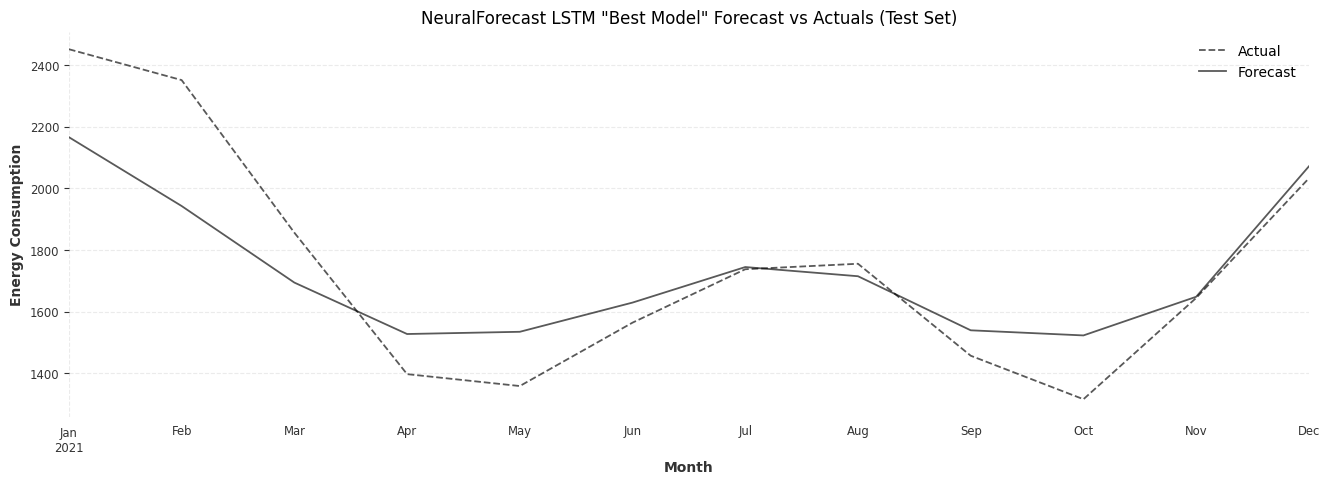

In [86]:
plt.figure(figsize=(16, 5))
test_nf['y'].plot(label='Actual', linestyle='--', alpha=0.65)
nf_forecast_bm['LSTM'].plot(label='Forecast', color='k', alpha=0.65)
plt.title('NeuralForecast LSTM "Best Model" Forecast vs Actuals (Test Set)')
plt.xlabel('Month')
plt.ylabel('Energy Consumption')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# Multivariate Time Series

Components Descriptions:

* Value_NE5 : Households & SMEs electricity consumption (low voltage, grid level 7) in kWh
* Value_NE7 : Business and services electricity consumption (medium voltage, grid level 5) in kWh
* Hr [%Hr] : Relative humidity
* RainDur [min] : Duration of precipitation (divided by 4 for conversion from hourly to quarter-hourly records)
* T [°C] : Temperature
* WD [°] : Wind direction
* WVv [m/s] : Wind vector speed
* p [hPa] : Air pressure
* WVs [m/s] : Wind scalar speed
* StrGlo [W/m2] : Global solar irradiation

## Darts BlockRNNModel

In [89]:
from darts.metrics import rmse, mae
from darts.dataprocessing.transformers import Scaler
from darts.models import BlockRNNModel
from darts.datasets import ElectricityConsumptionZurichDataset

import pandas as pd
import numpy as np
from pytorch_lightning.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler
import torch
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = [14, 7]

In [92]:
zurich = (ElectricityConsumptionZurichDataset()
                .load()
                .resample(freq="D", 
                          method='mean')
                 .astype(np.float32))

In [93]:
type(zurich)

darts.timeseries.TimeSeries

In [96]:
cov = ["T [°C]", "StrGlo [W/m2]", "RainDur [min]", "Hr [%Hr]"]
target = ["Value_NE5"]

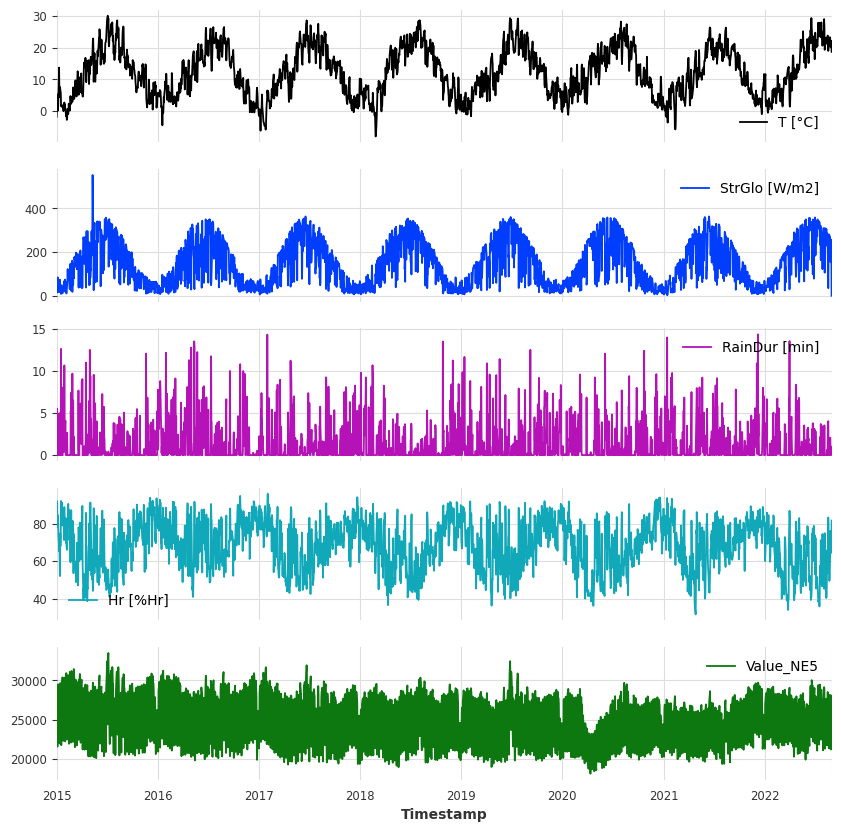

In [97]:
# convert to a pandas' DataFrame
zurich_df = zurich.to_dataframe() # will be used with NeuralForecast later
zurich_df[cov+target].plot(subplots=True, figsize=(10,10));

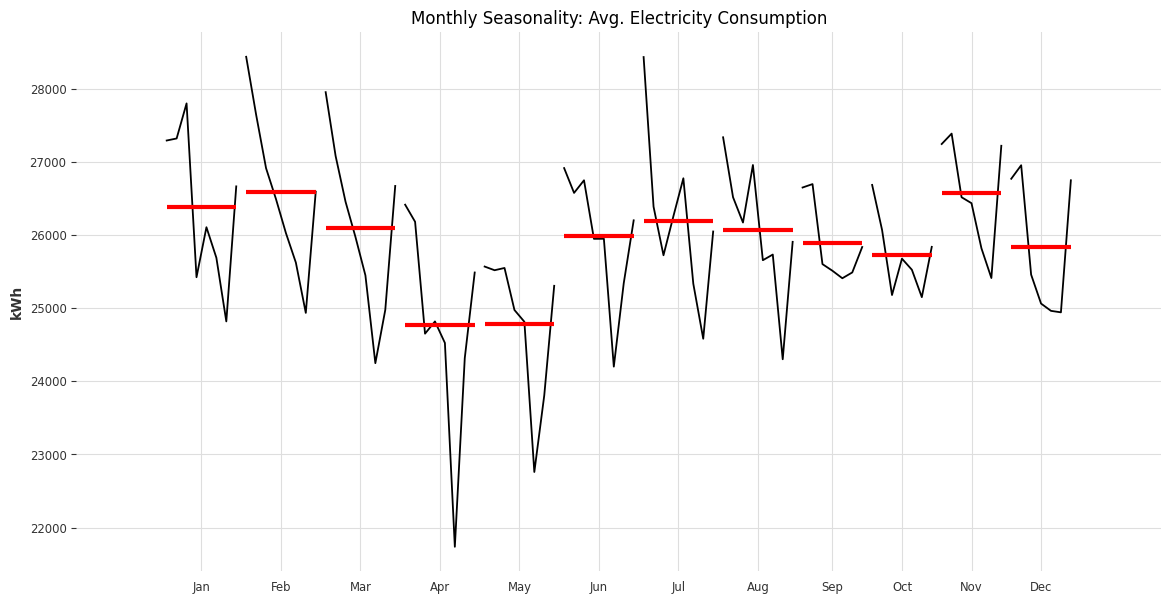

In [98]:
from statsmodels.graphics.tsaplots import month_plot, quarter_plot

# Resample target to monthly/quarterly for clearer seasonality
monthly_target = zurich_df[target].resample('ME').mean()
quarterly_target = zurich_df[target].resample('QE').mean()

month_plot(monthly_target, ylabel='kWh')
plt.title('Monthly Seasonality: Avg. Electricity Consumption')
plt.show()

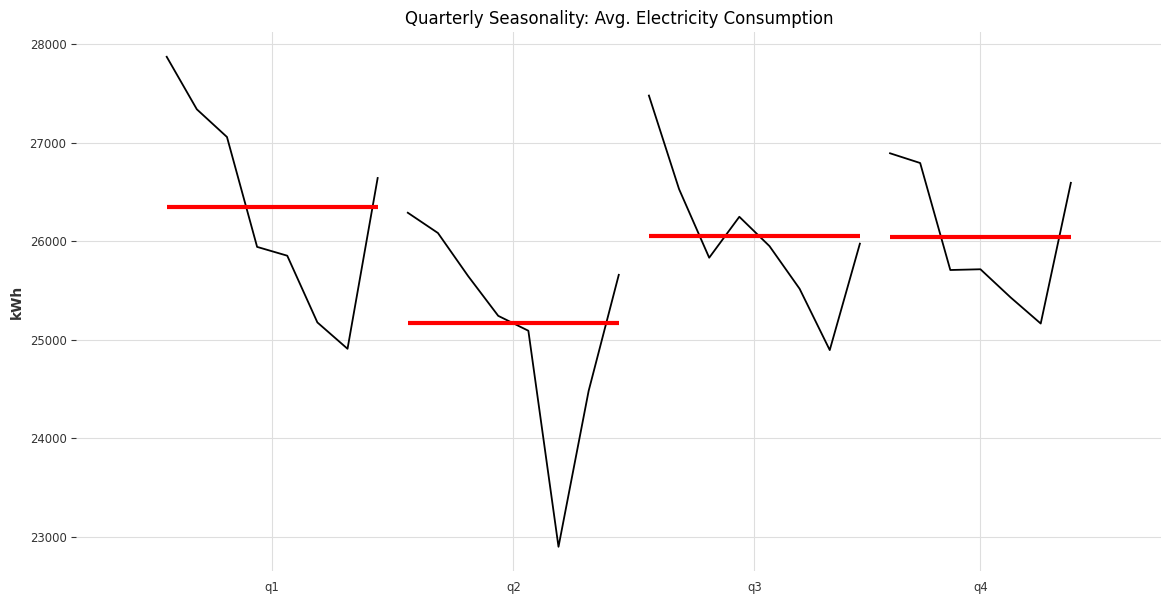

In [99]:
quarter_plot(quarterly_target, ylabel='kWh')
plt.title('Quarterly Seasonality: Avg. Electricity Consumption')
plt.show()

In [100]:
zurich_cov = zurich[cov]
zurich_en = zurich[target]

In [101]:
def split_ts(data, test_size, val_size):
    """
    Split time series data maintaining temporal order.
    
    Parameters:
    - test_size: number of periods for final testing
    - val_size: number of periods for validation
    """
    n_total = len(data)
    test_start = n_total - test_size
    val_start = test_start - val_size

    train = data[:val_start]
    val = data[val_start:test_start]
    test = data[test_start:]

    return train, val, test

In [102]:
# Create splits maintaining temporal order
d_zen_train, d_zen_val, d_zen_test = split_ts(zurich_en, 30, 160)

print(f'''
Zurich Energy train: {len(d_zen_train)}
Zurich Energy val : {len(d_zen_val)}
Zurich Energy test: {len(d_zen_test)}''')

d_cov_train, d_cov_val, d_cov_test = split_ts(zurich_cov, 30, 160)

print(f'''
Zurich Covariates train: {len(d_cov_train)}
Zurich Covariates val : {len(d_cov_val)}
Zurich Covariates test: {len(d_cov_test)}''')


Zurich Energy train: 2610
Zurich Energy val : 160
Zurich Energy test: 30

Zurich Covariates train: 2610
Zurich Covariates val : 160
Zurich Covariates test: 30


In [103]:
scaler_target = Scaler(StandardScaler())

d_zen_train_sc= scaler_target.fit_transform(d_zen_train)
d_zen_val_sc = scaler_target.transform(d_zen_val)
d_zen_test_sc = scaler_target.transform(d_zen_test)

# Covariates time series 
scaler_cov = Scaler(StandardScaler())

d_cov_train_sc = scaler_cov.fit_transform(d_cov_train)
d_cov_val_sc = scaler_cov.transform(d_cov_val)
d_cov_test_sc = scaler_cov.transform(d_cov_test)

### Define Model Params

In [105]:
PATIENCE=15
early_stopper = EarlyStopping(
    monitor="val_loss", 
    patience=PATIENCE,  
    min_delta=0.001,    
    mode='min',         
    verbose=True)

trainer_kwargs = {
    "callbacks": [early_stopper],
    "enable_progress_bar": True, 
    "accelerator":"auto"}

lr_scheduler_kwargs = {
        "mode": "min",
        "monitor": "val_loss",
        "factor": 0.2,
        "patience": PATIENCE//3, 
        "min_lr": 1e-6,
        # "verbose": True
    }


In [106]:
model = BlockRNNModel(
    model="LSTM",
    input_chunk_length=120, # (4 months) captures seasonal patterns
    output_chunk_length=30, # 30 matches forecast horizon
    n_rnn_layers=2,
    hidden_dim=32,
    dropout=0.2,
    batch_size=32,
    n_epochs=500,
    optimizer_kwargs={"lr": 0.001},
    model_name="Zur_BlockRNN",
    log_tensorboard=True,
    random_state=42,
    force_reset=True,
    save_checkpoints=True,
    lr_scheduler_cls=torch.optim.lr_scheduler.ReduceLROnPlateau,
    lr_scheduler_kwargs= lr_scheduler_kwargs,
    pl_trainer_kwargs=trainer_kwargs 
)           



In [107]:
%%time
# Fit the model with transformed target data and covariates
model.fit(
    series=d_zen_train_sc,
    past_covariates=d_cov_train_sc,
    val_series=d_zen_val_sc,
    val_past_covariates=d_cov_val_sc, 
    verbose=True)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 13.4 K | train
6 | fc              | Sequential       | 33     | train
-------------------------------------------------------------
13.5 K    Trainable params
0         Non-trainable params
13.5 K    Total params
0.054     Total estimated model params size (MB)
8         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 77/77 [00:02<00:00, 29.74it/s, v_num=logs, train_loss=0.488, val_loss=0.496]

Metric val_loss improved. New best score: 0.496


Epoch 1: 100%|██████████| 77/77 [00:01<00:00, 49.37it/s, v_num=logs, train_loss=0.252, val_loss=0.139]

Metric val_loss improved by 0.357 >= min_delta = 0.001. New best score: 0.139


Epoch 2: 100%|██████████| 77/77 [00:01<00:00, 51.84it/s, v_num=logs, train_loss=0.201, val_loss=0.094]

Metric val_loss improved by 0.045 >= min_delta = 0.001. New best score: 0.094


Epoch 3: 100%|██████████| 77/77 [00:01<00:00, 49.81it/s, v_num=logs, train_loss=0.133, val_loss=0.0765]

Metric val_loss improved by 0.017 >= min_delta = 0.001. New best score: 0.077


Epoch 4: 100%|██████████| 77/77 [00:01<00:00, 48.82it/s, v_num=logs, train_loss=0.136, val_loss=0.069] 

Metric val_loss improved by 0.008 >= min_delta = 0.001. New best score: 0.069


Epoch 5: 100%|██████████| 77/77 [00:01<00:00, 50.82it/s, v_num=logs, train_loss=0.170, val_loss=0.0666]

Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.067


Epoch 6: 100%|██████████| 77/77 [00:01<00:00, 50.82it/s, v_num=logs, train_loss=0.174, val_loss=0.0636]

Metric val_loss improved by 0.003 >= min_delta = 0.001. New best score: 0.064


Epoch 7: 100%|██████████| 77/77 [00:01<00:00, 50.50it/s, v_num=logs, train_loss=0.167, val_loss=0.062]  

Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.062


Epoch 22: 100%|██████████| 77/77 [00:01<00:00, 51.47it/s, v_num=logs, train_loss=0.0991, val_loss=0.0679]

Monitored metric val_loss did not improve in the last 15 records. Best score: 0.062. Signaling Trainer to stop.


Epoch 22: 100%|██████████| 77/77 [00:01<00:00, 51.01it/s, v_num=logs, train_loss=0.0991, val_loss=0.0679]
CPU times: user 22.2 s, sys: 2.96 s, total: 25.2 s
Wall time: 36.6 s


BlockRNNModel(output_chunk_shift=0, model=LSTM, hidden_dim=32, n_rnn_layers=2, hidden_fc_sizes=None, dropout=0.2, activation=ReLU, use_static_covariates=True, input_chunk_length=120, output_chunk_length=30, batch_size=32, n_epochs=500, optimizer_kwargs={'lr': 0.001}, model_name=Zur_BlockRNN, log_tensorboard=True, random_state=42, force_reset=True, save_checkpoints=True, lr_scheduler_cls=<class 'torch.optim.lr_scheduler.ReduceLROnPlateau'>, lr_scheduler_kwargs={'mode': 'min', 'monitor': 'val_loss', 'factor': 0.2, 'patience': 5, 'min_lr': 1e-06}, pl_trainer_kwargs={'callbacks': [<pytorch_lightning.callbacks.early_stopping.EarlyStopping object at 0x369021c90>], 'enable_progress_bar': True, 'accelerator': 'auto'})

In [108]:
zen_best_model = model.load_from_checkpoint(
                               model_name="Zur_BlockRNN", 
                               best=True)
zen_best_model

BlockRNNModel(output_chunk_shift=0, model=LSTM, hidden_dim=32, n_rnn_layers=2, hidden_fc_sizes=None, dropout=0.2, activation=ReLU, use_static_covariates=True, input_chunk_length=120, output_chunk_length=30, batch_size=32, n_epochs=500, optimizer_kwargs={'lr': 0.001}, model_name=Zur_BlockRNN, log_tensorboard=True, random_state=42, force_reset=True, save_checkpoints=True, lr_scheduler_cls=<class 'torch.optim.lr_scheduler.ReduceLROnPlateau'>, lr_scheduler_kwargs={'mode': 'min', 'monitor': 'val_loss', 'factor': 0.2, 'patience': 5, 'min_lr': 1e-06}, pl_trainer_kwargs={'callbacks': [<pytorch_lightning.callbacks.early_stopping.EarlyStopping object at 0x367ca6090>], 'enable_progress_bar': True, 'accelerator': 'auto'})

In [109]:
d_zen_train_val_sc = d_zen_train_sc.append(d_zen_val_sc)
d_cov_train_val_sc = d_cov_train_sc.append(d_cov_val_sc)

zen_forecast_sc = zen_best_model.predict(
    n=len(d_zen_test_sc),
    series=d_zen_train_val_sc,
    past_covariates=d_cov_train_val_sc)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  3.99it/s]


In [110]:
zen_forecast_inv = scaler_target.inverse_transform(zen_forecast_sc)
# zen_forecast_inv.plot()

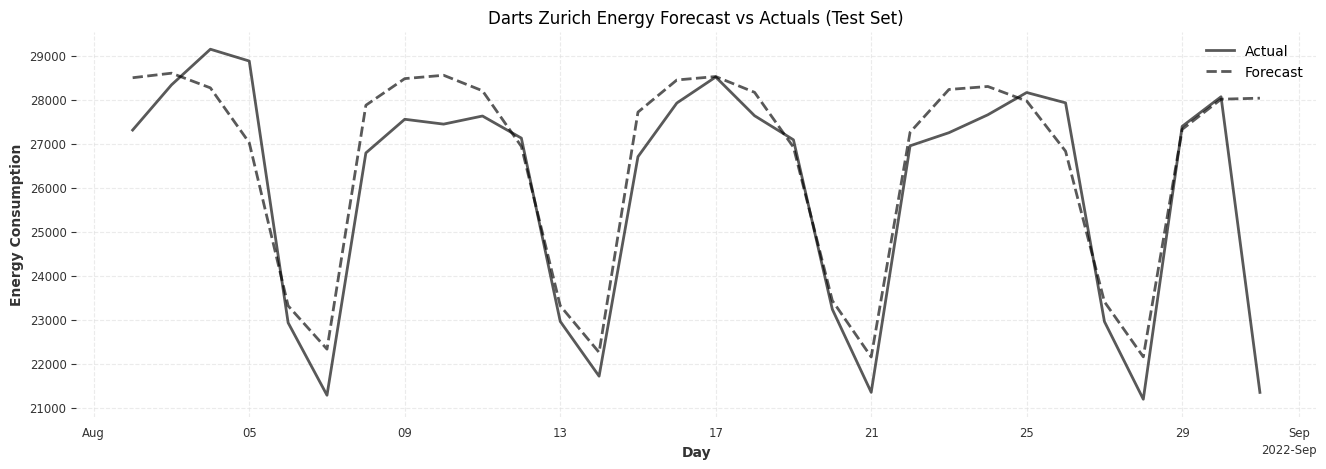

In [111]:
plt.figure(figsize=(16, 5))
d_zen_test.plot(label='Actual', linestyle='-', alpha=0.65)
zen_forecast_inv.plot(label='Forecast', color='k', linestyle='--', alpha=0.65)
plt.title('Darts Zurich Energy Forecast vs Actuals (Test Set)')
plt.xlabel('Day')
plt.ylabel('Energy Consumption')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

In [112]:
rmse_val = rmse(d_zen_test, zen_forecast_inv)
mae_val = mae(d_zen_test, zen_forecast_inv)
print(f"Darts Test Set MAE:  {mae_val:.4f}")
print(f"Darts Test Set RMSE: {rmse_val:.4f}")

Darts Test Set MAE:  835.9444
Darts Test Set RMSE: 1435.1460


## NeuralForecast

In [113]:
from neuralforecast import NeuralForecast
from neuralforecast.models import LSTM as NF_LSTM
from neuralforecast.losses.pytorch import MAE, MSE
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import ModelCheckpoint
from sklearn.metrics import mean_absolute_error, mean_squared_error

logger = TensorBoardLogger("nf_tensorboard_log", name="LSTM_Multi")

In [114]:
zurich_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2800 entries, 2015-01-01 to 2022-08-31
Freq: D
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Value_NE5      2800 non-null   float32
 1   Value_NE7      2800 non-null   float32
 2   Hr [%Hr]       2800 non-null   float32
 3   RainDur [min]  2800 non-null   float32
 4   StrGlo [W/m2]  2800 non-null   float32
 5   T [°C]         2800 non-null   float32
 6   WD [°]         2800 non-null   float32
 7   WVs [m/s]      2800 non-null   float32
 8   WVv [m/s]      2800 non-null   float32
 9   p [hPa]        2800 non-null   float32
dtypes: float32(10)
memory usage: 131.2 KB


In [115]:
zurich_nf_df = zurich_df[target+cov].reset_index()

In [116]:
zurich_nf_df.head()

component,Timestamp,Value_NE5,T [°C],StrGlo [W/m2],RainDur [min],Hr [%Hr]
0,2015-01-01,22354.730469,-1.820833,20.546875,0.000000,87.858643
1,2015-01-02,23320.701172,0.948750,26.653229,4.643125,91.988853
2,2015-01-03,23192.982422,5.255208,15.165104,5.505625,91.880836
3,2015-01-04,21553.050781,4.378438,47.625523,1.090417,78.207397
4,2015-01-05,29087.230469,0.906563,84.143852,0.000000,80.368645


In [117]:
zurich_nf_df.rename(columns={'Timestamp': 'ds', 'Value_NE5': 'y'}, inplace=True)
zurich_nf_df['unique_id'] = 'ZurichEnergy'
zurich_nf_df.head()

component,ds,y,T [°C],StrGlo [W/m2],RainDur [min],Hr [%Hr],unique_id
0,2015-01-01,22354.730469,-1.820833,20.546875,0.000000,87.858643,ZurichEnergy
1,2015-01-02,23320.701172,0.948750,26.653229,4.643125,91.988853,ZurichEnergy
2,2015-01-03,23192.982422,5.255208,15.165104,5.505625,91.880836,ZurichEnergy
3,2015-01-04,21553.050781,4.378438,47.625523,1.090417,78.207397,ZurichEnergy
4,2015-01-05,29087.230469,0.906563,84.143852,0.000000,80.368645,ZurichEnergy


In [118]:
TEST_LENGTH=30
WINDOW_SIZE=120

nf_zurich_test = zurich_nf_df.iloc[-TEST_LENGTH:]
nf_zurich_train = zurich_nf_df.iloc[:-TEST_LENGTH]

In [119]:
import math

batch_size = 32
steps_per_epoch = math.ceil(len(nf_zurich_train) / batch_size)
steps_per_epoch

87

In [120]:
# Add checkpoint callback
checkpoint_callback = ModelCheckpoint(
    monitor="valid_loss",
    mode="min",
    save_top_k=1)

In [121]:
# NeuralForecast LSTM parameters
PATIENCE = 15
nf_lstm_params = {
    'h': TEST_LENGTH, 
    'input_size': WINDOW_SIZE, 
    'encoder_n_layers': 2, 
    'encoder_hidden_size': 32, 
    'encoder_dropout': 0.2, 
    'max_steps': steps_per_epoch * 500, 
    'batch_size': batch_size, 
    'learning_rate': 0.001, 
    'num_lr_decays': PATIENCE//3,
    'early_stop_patience_steps': PATIENCE, 
    'val_check_steps': steps_per_epoch,
    'scaler_type': 'standard', 
    'random_seed': 42, 
    'logger': logger, 
    'enable_checkpointing': True,
    'callbacks': [checkpoint_callback],
    'hist_exog_list': cov 
}
# Instantiate the NeuralForecast LSTM model
nf_lstm = NF_LSTM(**nf_lstm_params)


# Define the models to be used in NeuralForecast
models = [nf_lstm]

# Create the NeuralForecast object
nf_lstm_model = NeuralForecast(models=models, freq='D')



Seed set to 42


In [122]:
%%time
# Fit the model. 
#NeuralForecast handles data splitting internally for validation
nf_lstm_model.fit(df=nf_zurich_train, val_size= 160) 

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | hist_encoder | LSTM          | 13.4 K | train
4 | mlp_decoder  | MLP           | 4.4 K  | train
-------------------------------------------------------
17.8 K    Trainable params
0         Non-trainable params
17.8 K    Total params
0.071     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode


Epoch 1478: 100%|██████████| 1/1 [00:00<00:00, 14.46it/s, v_num=0, train_loss_step=0.196, train_loss_epoch=0.196, valid_loss=1.13e+3]
CPU times: user 27.2 s, sys: 6.07 s, total: 33.2 s
Wall time: 56.9 s


In [123]:
nf_pred = nf_lstm_model.predict()

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  1.35it/s]


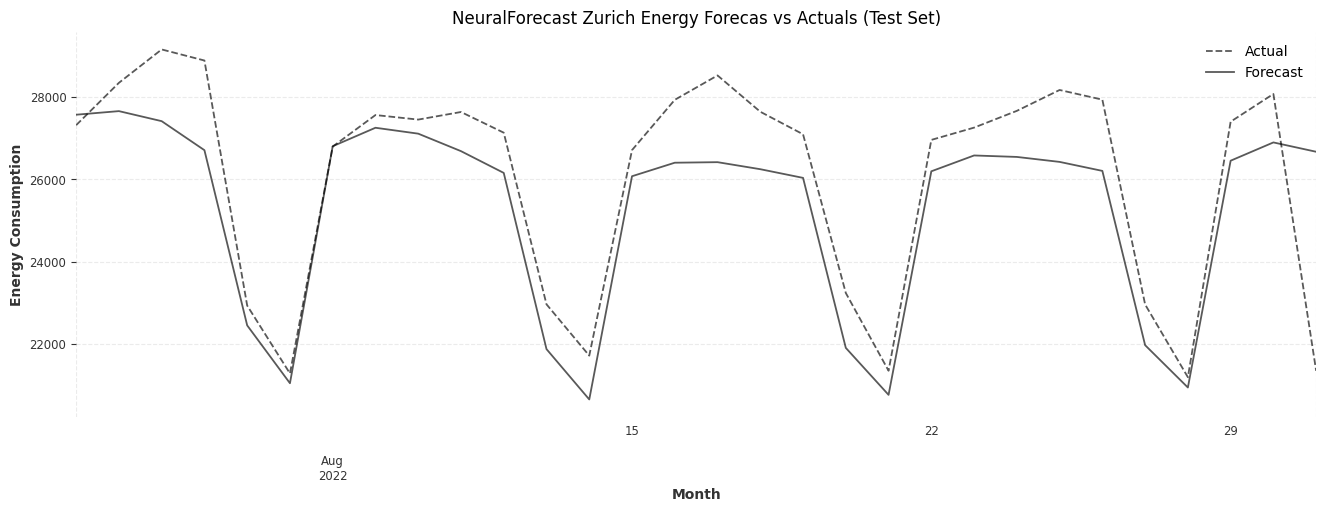

In [124]:
# Prepare the actual test data for plotting
nf_zurich_test.set_index('ds', inplace=True)

plt.figure(figsize=(16, 5))
nf_zurich_test['y'].plot(label='Actual', linestyle='--', alpha=0.65)
nf_pred.set_index('ds')['LSTM'].plot(label='Forecast', color='k', alpha=0.65)
plt.title('NeuralForecast Zurich Energy Forecas vs Actuals (Test Set)')
plt.xlabel('Month')
plt.ylabel('Energy Consumption')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()


In [125]:
# Calculate metrics
mae_nf = mean_absolute_error(nf_zurich_test['y'], nf_pred['LSTM'])
rmse_nf = np.sqrt(mean_squared_error(nf_zurich_test['y'], nf_pred['LSTM']))

print(f"NeuralForecast Test Set MAE:  {mae_nf:.4f}")
print(f"NeuralForecast Test Set RMSE: {rmse_nf:.4f}")

NeuralForecast Test Set MAE:  1121.0948
NeuralForecast Test Set RMSE: 1473.5518


### There is more

In [126]:
import pandas as pd

def add_time_covariates(df, ds_col='ds'):
    """
    Given a DataFrame with a DateTime column, returns a new DataFrame with added time-related future covariates.
    
    Returns:
        pd.DataFrame: DataFrame with additional time covariate columns.
    """
    df = df.copy()
    
    # Feature engineering
    df['hour'] = df[ds_col].dt.hour
    df['dayofweek'] = df[ds_col].dt.dayofweek
    df['month'] = df[ds_col].dt.month
    df['is_weekend'] = df[ds_col].dt.dayofweek.isin([5, 6]).astype(int)

    return df


nf_zurich_train_fc = add_time_covariates(nf_zurich_train, 'ds')
nf_zurich_test_fc = add_time_covariates(nf_zurich_test.reset_index(), 'ds')


In [127]:
fc_cov = ['hour', 'dayofweek', 'month', 'is_weekend']

In [128]:
%%time
# NeuralForecast LSTM parameters
nf_lstm_params_fc = {
    'h': TEST_LENGTH, 
    'input_size': WINDOW_SIZE, 
    'encoder_n_layers': 2, 
    'encoder_hidden_size': 32, 
    'encoder_dropout': 0.2, 
    'max_steps': steps_per_epoch * 500, 
    'batch_size': batch_size, 
    'learning_rate': 0.001, 
    'num_lr_decays': PATIENCE//3,
    'early_stop_patience_steps': PATIENCE, 
    'val_check_steps': steps_per_epoch,
    'scaler_type': 'standard', 
    'random_seed': 42, 
    'logger': logger, 
    'enable_checkpointing': True,
    'callbacks': [checkpoint_callback],
    'hist_exog_list': cov,
    'futr_exog_list': fc_cov 
}
# Instantiate the NeuralForecast LSTM model
nf_lstm_fc = NF_LSTM(**nf_lstm_params_fc)

# Define the models to be used in NeuralForecast
models_fc = [nf_lstm_fc]

# Create the NeuralForecast object
nf_lstm_model_fc = NeuralForecast(models=models_fc, freq='D')

nf_lstm_model_fc.fit(df=nf_zurich_train_fc, val_size= 160) 

Seed set to 42
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | hist_encoder | LSTM          | 14.0 K | train
4 | mlp_decoder  | MLP           | 4.9 K  | train
-------------------------------------------------------
18.8 K    Trainable params
0         Non-trainable params
18.8 K    Total params
0.075     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode


Epoch 1478: 100%|██████████| 1/1 [00:00<00:00, 16.22it/s, v_num=1, train_loss_step=0.114, train_loss_epoch=0.114, valid_loss=1.05e+3]
CPU times: user 28.4 s, sys: 6.3 s, total: 34.7 s
Wall time: 58.6 s


In [129]:
fc_cov.extend(['unique_id', 'ds'])
fc_cov

['hour', 'dayofweek', 'month', 'is_weekend', 'unique_id', 'ds']

In [130]:
fut_cov_df = nf_zurich_test_fc.loc[:, fc_cov] # extract future covariates
nf_pred_fc = nf_lstm_model_fc.predict(futr_df=fut_cov_df) # supply future covariates

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  2.70it/s]


In [131]:
# Calculate metrics
mae_nf = mean_absolute_error(nf_zurich_test['y'], nf_pred_fc['LSTM'])
rmse_nf = np.sqrt(mean_squared_error(nf_zurich_test['y'], nf_pred_fc['LSTM']))

print(f"NeuralForecast Test Set MAE:  {mae_nf:.4f}")
print(f"NeuralForecast Test Set RMSE: {rmse_nf:.4f}")

NeuralForecast Test Set MAE:  717.4011
NeuralForecast Test Set RMSE: 1374.3146


# Hyperparameter Tuning 

## Using Darts

In [121]:
# !pip install "optuna-integration[pytorch_lightning]"

In [187]:
import optuna

In [134]:
def objective(trial):
    # Suggest hyperparameters
    PATIENCE=15
    hidden_dim = trial.suggest_categorical("hidden_dim", [16, 32, 64])
    dropout = trial.suggest_float("dropout", 0.0, 0.3, step=0.1)
    lr = trial.suggest_categorical("lr", [1e-4, 1e-3, 1e-2])

    # Early stopping callback
    early_stopper = EarlyStopping(
        monitor="val_loss",
        patience=PATIENCE,
        min_delta=0.001,
        mode="min"
    )

    pl_trainer_kwargs = {
        "callbacks": [early_stopper],
        "accelerator": "auto"
    }

    lr_scheduler_kwargs = {
        "mode": "min",
        "monitor": "val_loss",
        "factor": 0.2,
        "patience": PATIENCE//3, 
        "min_lr": 1e-6,
        # "verbose": True
    }

    model_name = f"LSTMHyperTune_trial_{trial.number}"
    # Model instantiation
    model = BlockRNNModel(
        model="LSTM",
        input_chunk_length=120,
        output_chunk_length=30,
        n_rnn_layers=2,
        hidden_dim=hidden_dim,
        dropout=dropout,
        batch_size=32,
        n_epochs=500,
        optimizer_kwargs={"lr": lr},
        model_name=model_name,
        random_state=42,
        force_reset=True,
        save_checkpoints=True,
        loss_fn=torch.nn.L1Loss(), # to use MAE loss
        lr_scheduler_cls=torch.optim.lr_scheduler.ReduceLROnPlateau,
        lr_scheduler_kwargs= lr_scheduler_kwargs,
        pl_trainer_kwargs=pl_trainer_kwargs
    )

    # Fit the model
    model.fit(
        series=d_zen_train_sc,
        past_covariates=d_cov_train_sc,
        val_series=d_zen_val_sc,
        val_past_covariates=d_cov_val_sc,
        verbose=False
    )

    score = model.trainer.callback_metrics['val_loss'].item()

    return score

In [135]:
%%time

sampler = optuna.samplers.TPESampler(seed=42)
study = optuna.create_study(direction="minimize", sampler=sampler)
study.optimize(objective, n_trials=10)

print("Best trial:")
print(study.best_trial.params)
print("Best Validation MAE:", study.best_value)

[I 2025-10-08 21:39:24,192] A new study created in memory with name: no-name-df7b7865-8762-46df-b25c-445c6538181d
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
[I 2025-10-08 21:40:45,068] Trial 0 finished with value: 0.2573452591896057 and parameters: {'hidden_dim': 32, 'dropout': 0.2, 'lr': 0.0001}. Best is trial 0 with value: 0.2573452591896057.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
[I 2025-10-08 21:42:16,156] Trial 1 finished with value: 0.28433629870414734 and parameters: {'hidden_dim': 16, 'dropout': 0.0, 'lr': 0.0001}. Best is trial 0 with value: 0.2573452591896057.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
[I 2025-10-08 21:42:51,048] Trial 2 finished with value: 0.3255566358566284 and parameters: {'hidden_dim': 64, 'dropout': 0.2, 'lr': 0.01}. Best is trial 0 with

Best trial:
{'hidden_dim': 64, 'dropout': 0.1, 'lr': 0.0001}
Best Validation MAE: 0.24191126227378845
CPU times: user 5min 2s, sys: 27.3 s, total: 5min 29s
Wall time: 8min 26s


In [188]:
study.best_trial.params

{'hidden_dim': 64, 'dropout': 0.1, 'lr': 0.0001}

In [142]:
best_params = study.best_trial.params

In [143]:
PATIENCE=15
early_stopper = EarlyStopping(
    monitor="val_loss", 
    patience=PATIENCE,  
    min_delta=0.001,    
    mode='min',         
    verbose=True)

trainer_kwargs = {
    "callbacks": [early_stopper],
    "enable_progress_bar": True, 
    "accelerator":"auto"}

lr_scheduler_kwargs = {
        "mode": "min",
        "monitor": "val_loss",
        "factor": 0.2,
        "patience": PATIENCE//3, 
        "min_lr": 1e-6,
        # "verbose": True
    }

best_model = BlockRNNModel(
    model="LSTM",
    input_chunk_length=120,
    output_chunk_length=30,
    n_rnn_layers=2,
    hidden_dim=best_params['hidden_dim'],  # from Optuna
    dropout=best_params['dropout'],           # from Optuna
    batch_size=32,
    n_epochs=500,         
    optimizer_kwargs={"lr": best_params['lr']},  # from Optuna
    model_name="LSTMBestModel",
    random_state=42,
    force_reset=True,
    save_checkpoints=True,  # Set to True if you want to save checkpoints now
    loss_fn=torch.nn.L1Loss(),
    lr_scheduler_cls=torch.optim.lr_scheduler.ReduceLROnPlateau,
    lr_scheduler_kwargs= lr_scheduler_kwargs,
    pl_trainer_kwargs=trainer_kwargs)

In [144]:
%%time
# Fit the model with transformed target data and covariates
best_model.fit(
    series=d_zen_train_sc,
    past_covariates=d_cov_train_sc,
    val_series=d_zen_val_sc,
    val_past_covariates=d_cov_val_sc, 
    verbose=True)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | L1Loss           | 0      | train
1 | train_criterion | L1Loss           | 0      | train
2 | val_criterion   | L1Loss           | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 51.5 K | train
6 | fc              | Sequential       | 65     | train
-------------------------------------------------------------
51.5 K    Trainable params
0         Non-trainable params
51.5 K    Total params
0.206     Total estimated model params size (MB)
8         Modules in train mode
0         Modules in eval mode


Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 0: 100%|██████████| 77/77 [00:01<00:00, 45.01it/s, train_loss=0.764, val_loss=0.714]

Metric val_loss improved. New best score: 0.714


Epoch 2: 100%|██████████| 77/77 [00:01<00:00, 48.55it/s, train_loss=0.644, val_loss=0.713]

Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.713


Epoch 3: 100%|██████████| 77/77 [00:01<00:00, 48.22it/s, train_loss=0.528, val_loss=0.708]

Metric val_loss improved by 0.005 >= min_delta = 0.001. New best score: 0.708


Epoch 4: 100%|██████████| 77/77 [00:01<00:00, 48.86it/s, train_loss=0.498, val_loss=0.702]

Metric val_loss improved by 0.006 >= min_delta = 0.001. New best score: 0.702


Epoch 5: 100%|██████████| 77/77 [00:01<00:00, 48.13it/s, train_loss=0.436, val_loss=0.685]

Metric val_loss improved by 0.017 >= min_delta = 0.001. New best score: 0.685


Epoch 6: 100%|██████████| 77/77 [00:01<00:00, 47.65it/s, train_loss=0.382, val_loss=0.671]

Metric val_loss improved by 0.014 >= min_delta = 0.001. New best score: 0.671


Epoch 7: 100%|██████████| 77/77 [00:01<00:00, 47.54it/s, train_loss=0.387, val_loss=0.651]

Metric val_loss improved by 0.020 >= min_delta = 0.001. New best score: 0.651


Epoch 8: 100%|██████████| 77/77 [00:01<00:00, 47.77it/s, train_loss=0.360, val_loss=0.632]

Metric val_loss improved by 0.019 >= min_delta = 0.001. New best score: 0.632


Epoch 9: 100%|██████████| 77/77 [00:01<00:00, 47.62it/s, train_loss=0.320, val_loss=0.603]

Metric val_loss improved by 0.029 >= min_delta = 0.001. New best score: 0.603


Epoch 10: 100%|██████████| 77/77 [00:01<00:00, 47.76it/s, train_loss=0.302, val_loss=0.570]

Metric val_loss improved by 0.033 >= min_delta = 0.001. New best score: 0.570


Epoch 11: 100%|██████████| 77/77 [00:01<00:00, 47.80it/s, train_loss=0.295, val_loss=0.529]

Metric val_loss improved by 0.041 >= min_delta = 0.001. New best score: 0.529


Epoch 12: 100%|██████████| 77/77 [00:01<00:00, 48.80it/s, train_loss=0.294, val_loss=0.490]

Metric val_loss improved by 0.039 >= min_delta = 0.001. New best score: 0.490


Epoch 13: 100%|██████████| 77/77 [00:01<00:00, 46.28it/s, train_loss=0.295, val_loss=0.456]

Metric val_loss improved by 0.034 >= min_delta = 0.001. New best score: 0.456


Epoch 14: 100%|██████████| 77/77 [00:01<00:00, 48.93it/s, train_loss=0.333, val_loss=0.417]

Metric val_loss improved by 0.039 >= min_delta = 0.001. New best score: 0.417


Epoch 15: 100%|██████████| 77/77 [00:01<00:00, 47.80it/s, train_loss=0.266, val_loss=0.383]

Metric val_loss improved by 0.034 >= min_delta = 0.001. New best score: 0.383


Epoch 16: 100%|██████████| 77/77 [00:01<00:00, 47.55it/s, train_loss=0.268, val_loss=0.373]

Metric val_loss improved by 0.010 >= min_delta = 0.001. New best score: 0.373


Epoch 17: 100%|██████████| 77/77 [00:01<00:00, 48.88it/s, train_loss=0.305, val_loss=0.356]

Metric val_loss improved by 0.018 >= min_delta = 0.001. New best score: 0.356


Epoch 18: 100%|██████████| 77/77 [00:01<00:00, 48.69it/s, train_loss=0.288, val_loss=0.338]

Metric val_loss improved by 0.018 >= min_delta = 0.001. New best score: 0.338


Epoch 20: 100%|██████████| 77/77 [00:01<00:00, 48.07it/s, train_loss=0.260, val_loss=0.328]

Metric val_loss improved by 0.010 >= min_delta = 0.001. New best score: 0.328


Epoch 21: 100%|██████████| 77/77 [00:01<00:00, 48.38it/s, train_loss=0.232, val_loss=0.321]

Metric val_loss improved by 0.007 >= min_delta = 0.001. New best score: 0.321


Epoch 22: 100%|██████████| 77/77 [00:01<00:00, 47.90it/s, train_loss=0.249, val_loss=0.314]

Metric val_loss improved by 0.008 >= min_delta = 0.001. New best score: 0.314


Epoch 23: 100%|██████████| 77/77 [00:01<00:00, 48.39it/s, train_loss=0.247, val_loss=0.311]

Metric val_loss improved by 0.003 >= min_delta = 0.001. New best score: 0.311


Epoch 24: 100%|██████████| 77/77 [00:01<00:00, 47.62it/s, train_loss=0.201, val_loss=0.302]

Metric val_loss improved by 0.008 >= min_delta = 0.001. New best score: 0.302


Epoch 25: 100%|██████████| 77/77 [00:01<00:00, 48.23it/s, train_loss=0.202, val_loss=0.300]

Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.300


Epoch 26: 100%|██████████| 77/77 [00:01<00:00, 48.46it/s, train_loss=0.249, val_loss=0.293]

Metric val_loss improved by 0.007 >= min_delta = 0.001. New best score: 0.293


Epoch 28: 100%|██████████| 77/77 [00:01<00:00, 48.56it/s, train_loss=0.255, val_loss=0.281]

Metric val_loss improved by 0.012 >= min_delta = 0.001. New best score: 0.281


Epoch 30: 100%|██████████| 77/77 [00:01<00:00, 48.28it/s, train_loss=0.223, val_loss=0.279]

Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.279


Epoch 32: 100%|██████████| 77/77 [00:01<00:00, 48.60it/s, train_loss=0.246, val_loss=0.275]

Metric val_loss improved by 0.005 >= min_delta = 0.001. New best score: 0.275


Epoch 33: 100%|██████████| 77/77 [00:01<00:00, 48.25it/s, train_loss=0.212, val_loss=0.273]

Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.273


Epoch 34: 100%|██████████| 77/77 [00:01<00:00, 44.78it/s, train_loss=0.251, val_loss=0.271]

Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.271


Epoch 35: 100%|██████████| 77/77 [00:01<00:00, 47.48it/s, train_loss=0.251, val_loss=0.265]

Metric val_loss improved by 0.006 >= min_delta = 0.001. New best score: 0.265


Epoch 40: 100%|██████████| 77/77 [00:01<00:00, 47.38it/s, train_loss=0.223, val_loss=0.263]

Metric val_loss improved by 0.003 >= min_delta = 0.001. New best score: 0.263


Epoch 41: 100%|██████████| 77/77 [00:01<00:00, 47.70it/s, train_loss=0.187, val_loss=0.259]

Metric val_loss improved by 0.004 >= min_delta = 0.001. New best score: 0.259


Epoch 44: 100%|██████████| 77/77 [00:01<00:00, 48.21it/s, train_loss=0.194, val_loss=0.255]

Metric val_loss improved by 0.004 >= min_delta = 0.001. New best score: 0.255


Epoch 46: 100%|██████████| 77/77 [00:01<00:00, 47.31it/s, train_loss=0.214, val_loss=0.253]

Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.253


Epoch 48: 100%|██████████| 77/77 [00:01<00:00, 47.91it/s, train_loss=0.223, val_loss=0.251]

Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.251


Epoch 53: 100%|██████████| 77/77 [00:01<00:00, 47.92it/s, train_loss=0.214, val_loss=0.249]

Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.249


Epoch 55: 100%|██████████| 77/77 [00:01<00:00, 48.30it/s, train_loss=0.192, val_loss=0.248]

Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.248


Epoch 58: 100%|██████████| 77/77 [00:01<00:00, 48.55it/s, train_loss=0.182, val_loss=0.246]

Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.246


Epoch 64: 100%|██████████| 77/77 [00:01<00:00, 48.28it/s, train_loss=0.174, val_loss=0.243]

Metric val_loss improved by 0.003 >= min_delta = 0.001. New best score: 0.243


Epoch 78: 100%|██████████| 77/77 [00:01<00:00, 47.56it/s, train_loss=0.178, val_loss=0.241]

Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.241


Epoch 93: 100%|██████████| 77/77 [00:01<00:00, 48.90it/s, train_loss=0.167, val_loss=0.242]

Monitored metric val_loss did not improve in the last 15 records. Best score: 0.241. Signaling Trainer to stop.


Epoch 93: 100%|██████████| 77/77 [00:01<00:00, 48.45it/s, train_loss=0.167, val_loss=0.242]
CPU times: user 1min 32s, sys: 12.2 s, total: 1min 45s
Wall time: 2min 33s


BlockRNNModel(output_chunk_shift=0, model=LSTM, hidden_dim=64, n_rnn_layers=2, hidden_fc_sizes=None, dropout=0.1, activation=ReLU, use_static_covariates=True, input_chunk_length=120, output_chunk_length=30, batch_size=32, n_epochs=500, optimizer_kwargs={'lr': 0.0001}, model_name=LSTMBestModel, random_state=42, force_reset=True, save_checkpoints=True, loss_fn=L1Loss(), lr_scheduler_cls=<class 'torch.optim.lr_scheduler.ReduceLROnPlateau'>, lr_scheduler_kwargs={'mode': 'min', 'monitor': 'val_loss', 'factor': 0.2, 'patience': 5, 'min_lr': 1e-06}, pl_trainer_kwargs={'callbacks': [<pytorch_lightning.callbacks.early_stopping.EarlyStopping object at 0x368f2bb50>], 'enable_progress_bar': True, 'accelerator': 'auto'})

In [145]:
zen_best_model = best_model.load_from_checkpoint(
                               model_name="LSTMBestModel", 
                               best=True)
zen_best_model

BlockRNNModel(output_chunk_shift=0, model=LSTM, hidden_dim=64, n_rnn_layers=2, hidden_fc_sizes=None, dropout=0.1, activation=ReLU, use_static_covariates=True, input_chunk_length=120, output_chunk_length=30, batch_size=32, n_epochs=500, optimizer_kwargs={'lr': 0.0001}, model_name=LSTMBestModel, random_state=42, force_reset=True, save_checkpoints=True, loss_fn=L1Loss(), lr_scheduler_cls=<class 'torch.optim.lr_scheduler.ReduceLROnPlateau'>, lr_scheduler_kwargs={'mode': 'min', 'monitor': 'val_loss', 'factor': 0.2, 'patience': 5, 'min_lr': 1e-06}, pl_trainer_kwargs={'callbacks': [<pytorch_lightning.callbacks.early_stopping.EarlyStopping object at 0x368f168d0>], 'enable_progress_bar': True, 'accelerator': 'auto'})

In [146]:
d_zen_train_val_sc = d_zen_train_sc.append(d_zen_val_sc)
d_cov_train_val_sc = d_cov_train_sc.append(d_cov_val_sc)

zen_forecast_sc = zen_best_model.predict(
    n=len(d_zen_test_sc),
    series=d_zen_train_val_sc,
    past_covariates=d_cov_train_val_sc)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 59.98it/s]


In [147]:
zen_forecast_inv = scaler_target.inverse_transform(zen_forecast_sc)
# zen_forecast_inv.plot()

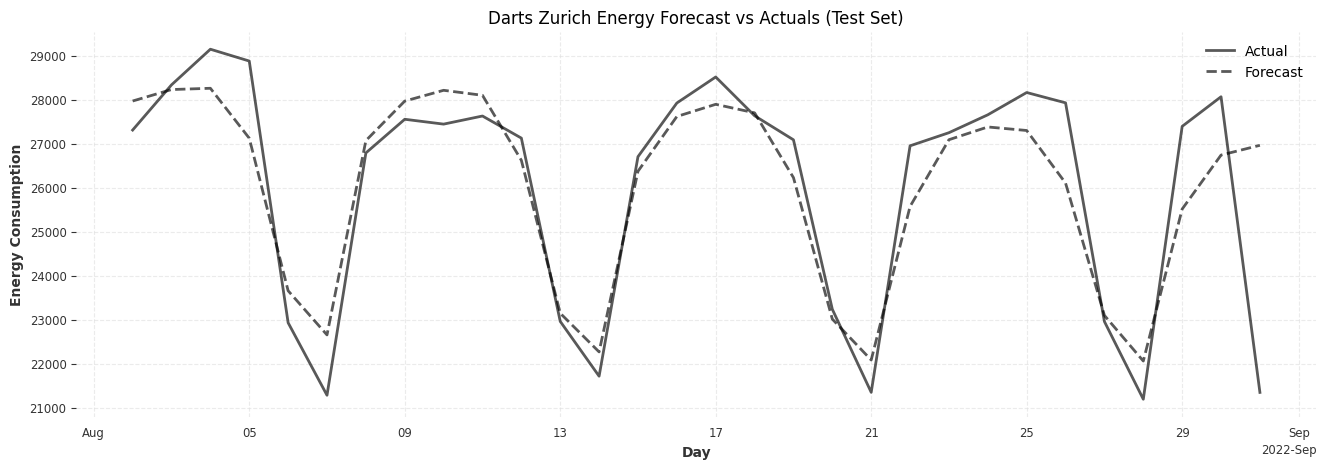

In [148]:
plt.figure(figsize=(16, 5))
d_zen_test.plot(label='Actual', linestyle='-', alpha=0.65)
zen_forecast_inv.plot(label='Forecast', color='k', linestyle='--', alpha=0.65)
plt.title('Darts Zurich Energy Forecast vs Actuals (Test Set)')
plt.xlabel('Day')
plt.ylabel('Energy Consumption')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

In [149]:
rmse_val = rmse(d_zen_test, zen_forecast_inv)
mae_val = mae(d_zen_test, zen_forecast_inv)
print(f"Darts Test Set MAE:  {mae_val:.4f}")
print(f"Darts Test Set RMSE: {rmse_val:.4f}")

Darts Test Set MAE:  871.1782
Darts Test Set RMSE: 1340.4065


In [150]:
zen_best_model.save("darts_tuned_model.pt")
model_loaded = BlockRNNModel.load("darts_tuned_model.pt")
model_loaded

BlockRNNModel(output_chunk_shift=0, model=LSTM, hidden_dim=64, n_rnn_layers=2, hidden_fc_sizes=None, dropout=0.1, activation=ReLU, use_static_covariates=True, input_chunk_length=120, output_chunk_length=30, batch_size=32, n_epochs=500, optimizer_kwargs={'lr': 0.0001}, model_name=LSTMBestModel, random_state=42, force_reset=True, save_checkpoints=True, loss_fn=L1Loss(), lr_scheduler_cls=<class 'torch.optim.lr_scheduler.ReduceLROnPlateau'>, lr_scheduler_kwargs={'mode': 'min', 'monitor': 'val_loss', 'factor': 0.2, 'patience': 5, 'min_lr': 1e-06}, pl_trainer_kwargs={'callbacks': [<pytorch_lightning.callbacks.early_stopping.EarlyStopping object at 0x36819ffd0>], 'enable_progress_bar': True, 'accelerator': 'auto'})

## Using NeuralForecast

In [151]:
import optuna
from neuralforecast.auto import AutoLSTM

In [152]:
# Use this to disable training prints from optuna
optuna.logging.set_verbosity(optuna.logging.WARNING) 

In [153]:
import math

TEST_LENGTH=30
WINDOW_SIZE=120

batch_size = 32
steps_per_epoch = math.ceil(len(nf_zurich_train) / batch_size)

# NeuralForecast LSTM parameters
PATIENCE = 15
nf_lstm_params = {
    'input_size': WINDOW_SIZE, 
    'encoder_n_layers': 2, 
    'encoder_hidden_size': 32, 
    'encoder_dropout': 0.2, 
    'max_steps': steps_per_epoch * 500, 
    'batch_size': batch_size, 
    'learning_rate': 0.001, 
    'num_lr_decays': PATIENCE//3,
    'early_stop_patience_steps': PATIENCE, 
    'val_check_steps': steps_per_epoch, 
    'scaler_type': 'standard', 
    'random_seed': 42, #
    'hist_exog_list': cov 
}

In [154]:
configs = {**nf_lstm_params}
configs.update({'learning_rate': 1000})
configs.get('learning_rate')

1000

In [155]:
def config_lstm(trial):
    # Start with a copy of the base parameters
    configs = {**nf_lstm_params}
	# Update with the hyperparameters to be tuned by Optuna
    configs.update(
        {"learning_rate": trial.suggest_categorical("learning_rate", [1e-4, 1e-3, 1e-2]),
         "encoder_hidden_size": trial.suggest_categorical("encoder_hidden_size", [16, 32, 64]),
         "encoder_dropout": trial.suggest_float("encoder_dropout", 0.0, 0.3, step=0.1)
        })

    return configs


In [156]:
hp_model = AutoLSTM(h=TEST_LENGTH,
                  loss=MAE(),
                  config=config_lstm,
                  search_alg=sampler, # defined in the Darts section
                  backend='optuna',
                  num_samples=10)

In [157]:
%%time
nf_hp = NeuralForecast(models=[hp_model], freq='D')
nf_hp.fit(df=nf_zurich_train, val_size= 160)

Seed set to 42
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | hist_encoder | LSTM          | 3.6 K  | train
4 | mlp_decoder  | MLP           | 2.3 K  | train
-------------------------------------------------------
6.0 K     Trainable params
0         Non-trainable params
6.0 K     Total params
0.024     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode


Epoch 5132: 100%|██████████| 1/1 [00:00<00:00, 16.89it/s, v_num=0, train_loss_step=0.297, train_loss_epoch=0.297, valid_loss=873.0]  


Seed set to 42
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | hist_encoder | LSTM          | 3.6 K  | train
4 | mlp_decoder  | MLP           | 2.3 K  | train
-------------------------------------------------------
6.0 K     Trainable params
0         Non-trainable params
6.0 K     Total params
0.024     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode


Epoch 1652: 100%|██████████| 1/1 [00:00<00:00, 16.23it/s, v_num=1, train_loss_step=0.189, train_loss_epoch=0.189, valid_loss=962.0]  


Seed set to 42
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | hist_encoder | LSTM          | 13.4 K | train
4 | mlp_decoder  | MLP           | 4.4 K  | train
-------------------------------------------------------
17.8 K    Trainable params
0         Non-trainable params
17.8 K    Total params
0.071     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode


Epoch 1391: 100%|██████████| 1/1 [00:00<00:00, 14.03it/s, v_num=2, train_loss_step=0.0454, train_loss_epoch=0.0454, valid_loss=1.21e+3]


Seed set to 42
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | hist_encoder | LSTM          | 3.6 K  | train
4 | mlp_decoder  | MLP           | 2.3 K  | train
-------------------------------------------------------
6.0 K     Trainable params
0         Non-trainable params
6.0 K     Total params
0.024     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode


Epoch 3653: 100%|██████████| 1/1 [00:00<00:00, 18.04it/s, v_num=3, train_loss_step=0.189, train_loss_epoch=0.189, valid_loss=1.09e+3]


Seed set to 42
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | hist_encoder | LSTM          | 3.6 K  | train
4 | mlp_decoder  | MLP           | 2.3 K  | train
-------------------------------------------------------
6.0 K     Trainable params
0         Non-trainable params
6.0 K     Total params
0.024     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode


Epoch 1826: 100%|██████████| 1/1 [00:00<00:00, 17.88it/s, v_num=4, train_loss_step=0.262, train_loss_epoch=0.262, valid_loss=870.0] 


Seed set to 42
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | hist_encoder | LSTM          | 51.5 K | train
4 | mlp_decoder  | MLP           | 8.4 K  | train
-------------------------------------------------------
59.9 K    Trainable params
0         Non-trainable params
59.9 K    Total params
0.240     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode


Epoch 1391: 100%|██████████| 1/1 [00:00<00:00, 16.97it/s, v_num=5, train_loss_step=0.0178, train_loss_epoch=0.0178, valid_loss=1.04e+3]


Seed set to 42
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | hist_encoder | LSTM          | 3.6 K  | train
4 | mlp_decoder  | MLP           | 2.3 K  | train
-------------------------------------------------------
6.0 K     Trainable params
0         Non-trainable params
6.0 K     Total params
0.024     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode


Epoch 5132: 100%|██████████| 1/1 [00:00<00:00, 19.30it/s, v_num=6, train_loss_step=0.297, train_loss_epoch=0.297, valid_loss=873.0]  


Seed set to 42
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | hist_encoder | LSTM          | 3.6 K  | train
4 | mlp_decoder  | MLP           | 2.3 K  | train
-------------------------------------------------------
6.0 K     Trainable params
0         Non-trainable params
6.0 K     Total params
0.024     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode


Epoch 3653: 100%|██████████| 1/1 [00:00<00:00, 16.16it/s, v_num=7, train_loss_step=0.213, train_loss_epoch=0.213, valid_loss=1.27e+3]

Seed set to 42


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | hist_encoder | LSTM          | 3.6 K  | train
4 | mlp_decoder  | MLP           | 2.3 K  | train
-------------------------------------------------------
6.0 K     Trainable params
0         Non-trainable params
6.0 K     Total params
0.024     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode


Epoch 1652: 100%|██████████| 1/1 [00:00<00:00, 18.95it/s, v_num=8, train_loss_step=0.189, train_loss_epoch=0.189, valid_loss=962.0]  


Seed set to 42
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | hist_encoder | LSTM          | 13.4 K | train
4 | mlp_decoder  | MLP           | 4.4 K  | train
-------------------------------------------------------
17.8 K    Trainable params
0         Non-trainable params
17.8 K    Total params
0.071     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode


Epoch 1565: 100%|██████████| 1/1 [00:00<00:00, 15.21it/s, v_num=9, train_loss_step=0.188, train_loss_epoch=0.188, valid_loss=964.0]  


Seed set to 42
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | hist_encoder | LSTM          | 3.6 K  | train
4 | mlp_decoder  | MLP           | 2.3 K  | train
-------------------------------------------------------
6.0 K     Trainable params
0         Non-trainable params
6.0 K     Total params
0.024     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode


Epoch 1826: 100%|██████████| 1/1 [00:00<00:00, 18.08it/s, v_num=10, train_loss_step=0.262, train_loss_epoch=0.262, valid_loss=870.0] 
CPU times: user 8min 34s, sys: 1min 47s, total: 10min 21s
Wall time: 16min 54s


In [158]:
nf_hp.models[0].results.best_trial

FrozenTrial(number=4, state=1, values=[870.3497314453125], datetime_start=datetime.datetime(2025, 10, 8, 22, 6, 9, 845214), datetime_complete=datetime.datetime(2025, 10, 8, 22, 7, 12, 724973), params={'learning_rate': 0.001, 'encoder_hidden_size': 16, 'encoder_dropout': 0.3}, user_attrs={'ALL_PARAMS': {'input_size': 120, 'encoder_n_layers': 2, 'encoder_hidden_size': 16, 'encoder_dropout': 0.3, 'max_steps': 43500, 'batch_size': 32, 'learning_rate': 0.001, 'num_lr_decays': 5, 'early_stop_patience_steps': 15, 'val_check_steps': 87, 'scaler_type': 'standard', 'random_seed': 42, 'hist_exog_list': ['T [°C]', 'StrGlo [W/m2]', 'RainDur [min]', 'Hr [%Hr]'], 'h': 30, 'loss': MAE(), 'valid_loss': MAE()}, 'METRICS': {'loss': tensor(870.3497), 'train_loss': tensor(0.2622)}}, system_attrs={}, intermediate_values={}, distributions={'learning_rate': CategoricalDistribution(choices=(0.0001, 0.001, 0.01)), 'encoder_hidden_size': CategoricalDistribution(choices=(16, 32, 64)), 'encoder_dropout': FloatDist

In [159]:
nf_hp.models[0].results.best_trial.params

{'learning_rate': 0.001, 'encoder_hidden_size': 16, 'encoder_dropout': 0.3}

In [160]:
results = nf_hp.models[0].results.trials_dataframe()

In [161]:
results

,number,value,datetime_start,datetime_complete,duration,params_encoder_dropout,params_encoder_hidden_size,params_learning_rate,user_attrs_ALL_PARAMS,user_attrs_METRICS,state
0,0,873.367065,2025-10-08 21:59:16.709904,2025-10-08 22:02:14.311210,0 days 00:02:57.601306,0.3,16,0.0001,"{'input_size': 120, 'encoder_n_layers': 2, 'en...","{'loss': tensor(873.3671), 'train_loss': tenso...",COMPLETE
1,1,962.380127,2025-10-08 22:02:14.311249,2025-10-08 22:03:11.464158,0 days 00:00:57.152909,0.0,16,0.0010,"{'input_size': 120, 'encoder_n_layers': 2, 'en...","{'loss': tensor(962.3801), 'train_loss': tenso...",COMPLETE
2,2,1207.395630,2025-10-08 22:03:11.464190,2025-10-08 22:04:03.970420,0 days 00:00:52.506230,0.0,32,0.0100,"{'input_size': 120, 'encoder_n_layers': 2, 'en...","{'loss': tensor(1207.3956), 'train_loss': tens...",COMPLETE
3,3,1090.369507,2025-10-08 22:04:03.970449,2025-10-08 22:06:09.845188,0 days 00:02:05.874739,0.1,16,0.0010,"{'input_size': 120, 'encoder_n_layers': 2, 'en...","{'loss': tensor(1090.3695), 'train_loss': tens...",COMPLETE
4,4,870.349731,2025-10-08 22:06:09.845214,2025-10-08 22:07:12.724973,0 days 00:01:02.879759,0.3,16,0.0010,"{'input_size': 120, 'encoder_n_layers': 2, 'en...","{'loss': tensor(870.3497), 'train_loss': tenso...",COMPLETE
5,5,1040.810181,2025-10-08 22:07:12.725002,2025-10-08 22:08:10.006459,0 days 00:00:57.281457,0.0,64,0.0100,"{'input_size': 120, 'encoder_n_layers': 2, 'en...","{'loss': tensor(1040.8102), 'train_loss': tens...",COMPLETE
6,6,873.367065,2025-10-08 22:08:10.006489,2025-10-08 22:11:06.729127,0 days 00:02:56.722638,0.3,16,0.0001,"{'input_size': 120, 'encoder_n_layers': 2, 'en...","{'loss': tensor(873.3671), 'train_loss': tenso...",COMPLETE
7,7,1266.811890,2025-10-08 22:11:06.729155,2025-10-08 22:13:12.430132,0 days 00:02:05.700977,0.1,16,0.0100,"{'input_size': 120, 'encoder_n_layers': 2, 'en...","{'loss': tensor(1266.8119), 'train_loss': tens...",COMPLETE
8,8,962.380127,2025-10-08 22:13:12.430159,2025-10-08 22:14:09.535959,0 days 00:00:57.105800,0.0,16,0.0010,"{'input_size': 120, 'encoder_n_layers': 2, 'en...","{'loss': tensor(962.3801), 'train_loss': tenso...",COMPLETE
9,9,964.249084,2025-10-08 22:14:09.535992,2025-10-08 22:15:08.064672,0 days 00:00:58.528680,0.3,32,0.0010,"{'input_size': 120, 'encoder_n_layers': 2, 'en...","{'loss': tensor(964.2491), 'train_loss': tenso...",COMPLETE


In [162]:
results['user_attrs_ALL_PARAMS'][0]

{'input_size': 120,
 'encoder_n_layers': 2,
 'encoder_hidden_size': 16,
 'encoder_dropout': 0.3,
 'max_steps': 43500,
 'batch_size': 32,
 'learning_rate': 0.0001,
 'num_lr_decays': 5,
 'early_stop_patience_steps': 15,
 'val_check_steps': 87,
 'scaler_type': 'standard',
 'random_seed': 42,
 'hist_exog_list': ['T [°C]', 'StrGlo [W/m2]', 'RainDur [min]', 'Hr [%Hr]'],
 'h': 30,
 'loss': MAE(),
 'valid_loss': MAE()}

In [189]:
results['user_attrs_METRICS'][0]

{'loss': tensor(873.3671), 'train_loss': tensor(0.2968)}

In [164]:
results.drop(columns='user_attrs_ALL_PARAMS')

,number,value,datetime_start,datetime_complete,duration,params_encoder_dropout,params_encoder_hidden_size,params_learning_rate,user_attrs_METRICS,state
0,0,873.367065,2025-10-08 21:59:16.709904,2025-10-08 22:02:14.311210,0 days 00:02:57.601306,0.3,16,0.0001,"{'loss': tensor(873.3671), 'train_loss': tenso...",COMPLETE
1,1,962.380127,2025-10-08 22:02:14.311249,2025-10-08 22:03:11.464158,0 days 00:00:57.152909,0.0,16,0.0010,"{'loss': tensor(962.3801), 'train_loss': tenso...",COMPLETE
2,2,1207.395630,2025-10-08 22:03:11.464190,2025-10-08 22:04:03.970420,0 days 00:00:52.506230,0.0,32,0.0100,"{'loss': tensor(1207.3956), 'train_loss': tens...",COMPLETE
3,3,1090.369507,2025-10-08 22:04:03.970449,2025-10-08 22:06:09.845188,0 days 00:02:05.874739,0.1,16,0.0010,"{'loss': tensor(1090.3695), 'train_loss': tens...",COMPLETE
4,4,870.349731,2025-10-08 22:06:09.845214,2025-10-08 22:07:12.724973,0 days 00:01:02.879759,0.3,16,0.0010,"{'loss': tensor(870.3497), 'train_loss': tenso...",COMPLETE
5,5,1040.810181,2025-10-08 22:07:12.725002,2025-10-08 22:08:10.006459,0 days 00:00:57.281457,0.0,64,0.0100,"{'loss': tensor(1040.8102), 'train_loss': tens...",COMPLETE
6,6,873.367065,2025-10-08 22:08:10.006489,2025-10-08 22:11:06.729127,0 days 00:02:56.722638,0.3,16,0.0001,"{'loss': tensor(873.3671), 'train_loss': tenso...",COMPLETE
7,7,1266.811890,2025-10-08 22:11:06.729155,2025-10-08 22:13:12.430132,0 days 00:02:05.700977,0.1,16,0.0100,"{'loss': tensor(1266.8119), 'train_loss': tens...",COMPLETE
8,8,962.380127,2025-10-08 22:13:12.430159,2025-10-08 22:14:09.535959,0 days 00:00:57.105800,0.0,16,0.0010,"{'loss': tensor(962.3801), 'train_loss': tenso...",COMPLETE
9,9,964.249084,2025-10-08 22:14:09.535992,2025-10-08 22:15:08.064672,0 days 00:00:58.528680,0.3,32,0.0010,"{'loss': tensor(964.2491), 'train_loss': tenso...",COMPLETE


In [165]:
Y_hat_df_optuna = nf_hp.predict()
# Y_hat_df_optuna = Y_hat_df_optuna.reset_index()
# Y_hat_df_optuna.head()

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 44.59it/s]


In [168]:
# Calculate metrics
mae_nf = mean_absolute_error(nf_zurich_test['y'], Y_hat_df_optuna['AutoLSTM'])
rmse_nf = np.sqrt(mean_squared_error(nf_zurich_test['y'], Y_hat_df_optuna['AutoLSTM']))

print(f"NeuralForecast Test Set MAE:  {mae_nf:.4f}")
print(f"NeuralForecast Test Set RMSE: {rmse_nf:.4f}")

NeuralForecast Test Set MAE:  782.5295
NeuralForecast Test Set RMSE: 1273.3864


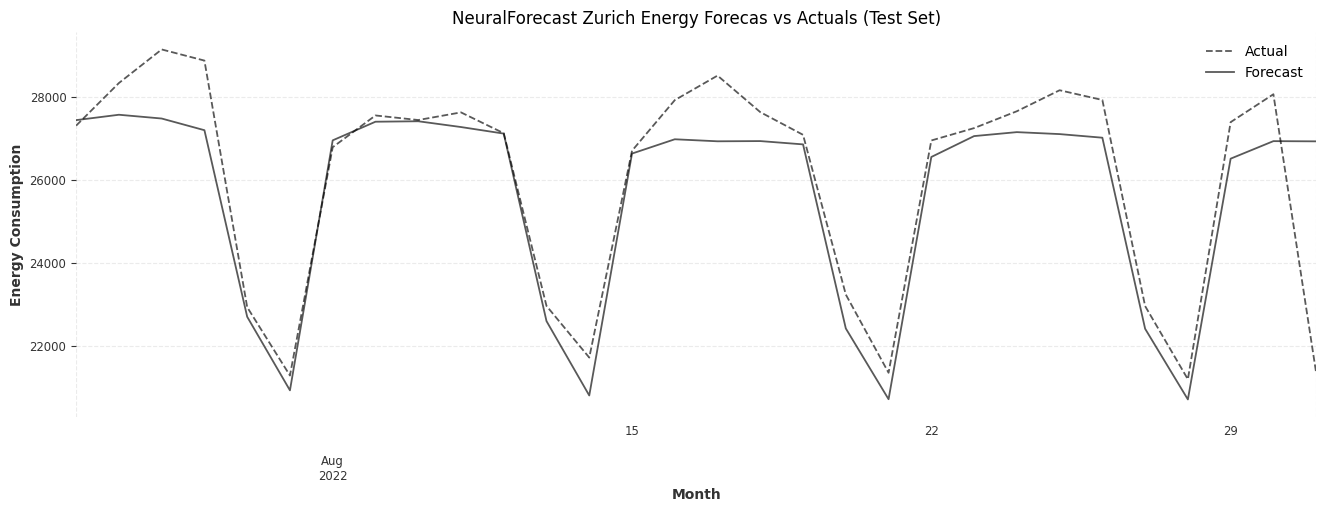

In [169]:
# Prepare the actual test data for plotting

plt.figure(figsize=(16, 5))
nf_zurich_test['y'].plot(label='Actual', linestyle='--', alpha=0.65)
Y_hat_df_optuna.set_index('ds')['AutoLSTM'].plot(label='Forecast', color='k', alpha=0.65)
plt.title('NeuralForecast Zurich Energy Forecas vs Actuals (Test Set)')
plt.xlabel('Month')
plt.ylabel('Energy Consumption')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()


In [170]:
nf_hp.save("nf_tuned_model")

In [171]:
from neuralforecast import NeuralForecast
nf_loaded = NeuralForecast.load("nf_tuned_model")

Seed set to 42


In [156]:
# nf_loaded.predict()

## There is more

In [1]:
# !pip install plotly
#!pip install nbformat

from optuna.visualization import (plot_optimization_history, 
                                 plot_param_importances,
                                 plot_timeline,
                                 plot_slice)

/Users/tarekatwan/Repos/MyWork/Write/Time-Series-Analysis-with-Python-Cookbook-Second-Edition/code/Ch13/dev1/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
# For darts
plot_optimization_history(study).show() 
plot_param_importances(study).show()    
plot_timeline(study).show() 
plot_slice(study).show()

In [30]:
# For NeuralForecast
plot_optimization_history(nf_study).show()
plot_param_importances(nf_study).show()
plot_timeline(nf_study).show()
plot_slice(nf_study).show()

In [21]:
optuna.importance.get_param_importances(study)

{'lr': np.float64(0.6188434412609206),
 'dropout': np.float64(0.19735062930681124),
 'hidden_dim': np.float64(0.18380592943226806)}

In [22]:
optuna.importance.get_param_importances(nf_study)

{'learning_rate': np.float64(0.5565634246557434),
 'encoder_dropout': np.float64(0.3179358506602426),
 'encoder_hidden_size': np.float64(0.12550072468401405)}

# Forecasting with Temporal Convolutional Networks (TCN)

## Using Darts TCNModel

In [195]:
from darts.models import TCNModel

In [200]:
PATIENCE=15
early_stopper = EarlyStopping(
    monitor="val_loss", 
    patience=PATIENCE,  
    min_delta=0.001,    
    mode='min',         
    verbose=True)

trainer_kwargs = {
    "callbacks": [early_stopper],
    "enable_progress_bar": True, 
    "accelerator":"auto"}

lr_scheduler_kwargs = {
        "mode": "min",
        "monitor": "val_loss",
        "factor": 0.2,
        "patience": PATIENCE//3, 
        "min_lr": 1e-6,
        # "verbose": True
    }

tcn_d_model = TCNModel(
    input_chunk_length=120,
    output_chunk_length=30,
    n_epochs=500,
    kernel_size=3, # TCNModel default
    num_filters=3, # TCNModel default
    dilation_base=2, # TCNModel default
    optimizer_kwargs={"lr": 0.001},
    weight_norm=True, # TCNModel default is False
    model_name="Zur_TCNModel",
    random_state=42,
    force_reset=True,
    save_checkpoints=True,
    lr_scheduler_cls=torch.optim.lr_scheduler.ReduceLROnPlateau,
    lr_scheduler_kwargs= lr_scheduler_kwargs,
    pl_trainer_kwargs=trainer_kwargs 
)


In [201]:
%%time
# Fit the model with transformed target data and covariates
tcn_d_model.fit(
    series=d_zen_train_sc,
    past_covariates=d_cov_train_sc,
    val_series=d_zen_val_sc,
    val_past_covariates=d_cov_val_sc, 
    verbose=True)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | res_blocks      | ModuleList       | 348    | train
-------------------------------------------------------------
348       Trainable params
0         Non-trainable params
348       Total params
0.001     Total estimated model params size (MB)
63        Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 77/77 [00:03<00:00, 21.01it/s, train_loss=1.010, val_loss=0.690]

Metric val_loss improved. New best score: 0.690


Epoch 1: 100%|██████████| 77/77 [00:01<00:00, 64.56it/s, train_loss=0.774, val_loss=0.520]

Metric val_loss improved by 0.170 >= min_delta = 0.001. New best score: 0.520


Epoch 2: 100%|██████████| 77/77 [00:01<00:00, 67.03it/s, train_loss=0.673, val_loss=0.378]

Metric val_loss improved by 0.141 >= min_delta = 0.001. New best score: 0.378


Epoch 3: 100%|██████████| 77/77 [00:01<00:00, 65.31it/s, train_loss=0.545, val_loss=0.325]

Metric val_loss improved by 0.053 >= min_delta = 0.001. New best score: 0.325


Epoch 4: 100%|██████████| 77/77 [00:01<00:00, 67.48it/s, train_loss=0.504, val_loss=0.289]

Metric val_loss improved by 0.037 >= min_delta = 0.001. New best score: 0.289


Epoch 5: 100%|██████████| 77/77 [00:01<00:00, 67.49it/s, train_loss=0.464, val_loss=0.275]

Metric val_loss improved by 0.014 >= min_delta = 0.001. New best score: 0.275


Epoch 6: 100%|██████████| 77/77 [00:01<00:00, 66.73it/s, train_loss=0.405, val_loss=0.266]

Metric val_loss improved by 0.009 >= min_delta = 0.001. New best score: 0.266


Epoch 7: 100%|██████████| 77/77 [00:01<00:00, 67.33it/s, train_loss=0.436, val_loss=0.259]

Metric val_loss improved by 0.006 >= min_delta = 0.001. New best score: 0.259


Epoch 8: 100%|██████████| 77/77 [00:01<00:00, 66.72it/s, train_loss=0.410, val_loss=0.257]

Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.257


Epoch 9: 100%|██████████| 77/77 [00:01<00:00, 66.32it/s, train_loss=0.384, val_loss=0.250]

Metric val_loss improved by 0.007 >= min_delta = 0.001. New best score: 0.250


Epoch 24: 100%|██████████| 77/77 [00:01<00:00, 67.82it/s, train_loss=0.348, val_loss=0.262]

Monitored metric val_loss did not improve in the last 15 records. Best score: 0.250. Signaling Trainer to stop.


Epoch 24: 100%|██████████| 77/77 [00:01<00:00, 65.85it/s, train_loss=0.348, val_loss=0.262]
CPU times: user 25.6 s, sys: 4.01 s, total: 29.6 s
Wall time: 33.6 s


TCNModel(output_chunk_shift=0, kernel_size=3, num_filters=3, num_layers=None, dilation_base=2, weight_norm=True, dropout=0.2, input_chunk_length=120, output_chunk_length=30, n_epochs=500, optimizer_kwargs={'lr': 0.001}, model_name=Zur_TCNModel, random_state=42, force_reset=True, save_checkpoints=True, lr_scheduler_cls=<class 'torch.optim.lr_scheduler.ReduceLROnPlateau'>, lr_scheduler_kwargs={'mode': 'min', 'monitor': 'val_loss', 'factor': 0.2, 'patience': 5, 'min_lr': 1e-06}, pl_trainer_kwargs={'callbacks': [<pytorch_lightning.callbacks.early_stopping.EarlyStopping object at 0x3cc09cf90>], 'enable_progress_bar': True, 'accelerator': 'auto'})

In [202]:
tcn_best_model = tcn_d_model.load_from_checkpoint(
                               model_name="Zur_TCNModel", 
                               best=True)
tcn_best_model

TCNModel(output_chunk_shift=0, kernel_size=3, num_filters=3, num_layers=None, dilation_base=2, weight_norm=True, dropout=0.2, input_chunk_length=120, output_chunk_length=30, n_epochs=500, optimizer_kwargs={'lr': 0.001}, model_name=Zur_TCNModel, random_state=42, force_reset=True, save_checkpoints=True, lr_scheduler_cls=<class 'torch.optim.lr_scheduler.ReduceLROnPlateau'>, lr_scheduler_kwargs={'mode': 'min', 'monitor': 'val_loss', 'factor': 0.2, 'patience': 5, 'min_lr': 1e-06}, pl_trainer_kwargs={'callbacks': [<pytorch_lightning.callbacks.early_stopping.EarlyStopping object at 0x3cb6d7ed0>], 'enable_progress_bar': True, 'accelerator': 'auto'})

In [203]:
d_zen_train_val_sc = d_zen_train_sc.append(d_zen_val_sc)
d_cov_train_val_sc = d_cov_train_sc.append(d_cov_val_sc)

tcn_forecast_sc = tcn_best_model.predict(
    n=len(d_zen_test),
    series=d_zen_train_val_sc,
    past_covariates=d_cov_train_val_sc)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  2.45it/s]


In [204]:
tcn_forecast_inv = scaler_target.inverse_transform(tcn_forecast_sc)


In [205]:
rmse_val = rmse(d_zen_test, tcn_forecast_inv)
mae_val = mae(d_zen_test, tcn_forecast_inv)
print(f"Darts Test Set MAE:  {mae_val:.4f}")
print(f"Darts Test Set RMSE: {rmse_val:.4f}")

Darts Test Set MAE:  744.4603
Darts Test Set RMSE: 1331.7764


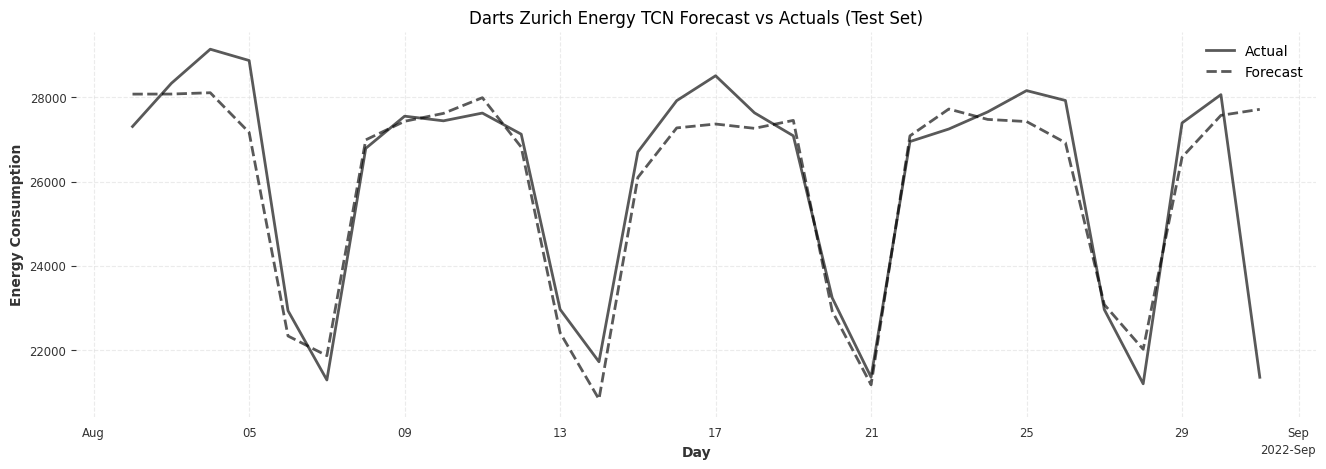

In [206]:
plt.figure(figsize=(16, 5))
d_zen_test.plot(label='Actual', linestyle='-', alpha=0.65)
tcn_forecast_inv.plot(label='Forecast', color='k', linestyle='--', alpha=0.65)
plt.title('Darts Zurich Energy TCN Forecast vs Actuals (Test Set)')
plt.xlabel('Day')
plt.ylabel('Energy Consumption')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

In [207]:
len(tcn_best_model.model.res_blocks)

5

In [208]:
tcn_best_model.model.res_blocks[1]

_ResidualBlock(
  (dropout1): MonteCarloDropout(p=0.2, inplace=False)
  (dropout2): MonteCarloDropout(p=0.2, inplace=False)
  (conv1): ParametrizedConv1d(
    3, 3, kernel_size=(3,), stride=(1,), dilation=(2,)
    (parametrizations): ModuleDict(
      (weight): ParametrizationList(
        (0): _WeightNorm()
      )
    )
  )
  (conv2): ParametrizedConv1d(
    3, 3, kernel_size=(3,), stride=(1,), dilation=(2,)
    (parametrizations): ModuleDict(
      (weight): ParametrizationList(
        (0): _WeightNorm()
      )
    )
  )
)

In [209]:
import math
# Parameters from our model
input_chunk_length = 120
dilation_base = 2
kernel_size = 3

# Darts' internal calculation for num_layers
num_layers = math.ceil(
    math.log(
        (input_chunk_length - 1) * (dilation_base - 1) / (kernel_size - 1) / 2 + 1,
        dilation_base,
    )
)

print(f"Calculated number of layers: {num_layers}")

Calculated number of layers: 5


## There is more

In [210]:
d_zen_test.shape

(30, 1, 1)

In [211]:
# check activation function
tcn_prob = tcn_best_model.predict(  
    n=len(d_zen_test),
    num_samples=200,
    mc_dropout=True, # Enable MC Dropout
    series=d_zen_train_val_sc,
    past_covariates=d_cov_train_val_sc,
    random_state=1)

tcn_prob_inv = scaler_target.inverse_transform(tcn_prob)


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  5.86it/s]


In [212]:
tcn_prob_inv.shape

(30, 1, 200)

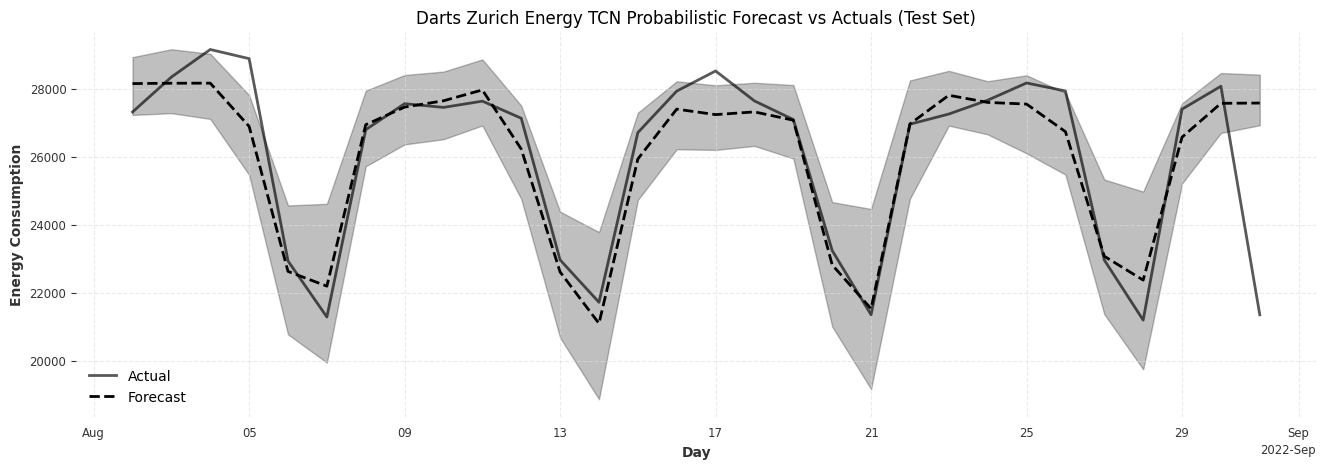

In [213]:

plt.figure(figsize=(16, 5))
d_zen_test.plot(label='Actual', linestyle='-', alpha=0.65)
tcn_prob_inv.plot(label='Forecast', 
                  color='k', 
                  linestyle='--', 
                  alpha=0.25, 
                  low_quantile=0.05, 
                  high_quantile=0.95, 
                  central_quantile=0.5)
plt.title('Darts Zurich Energy TCN Probabilistic Forecast vs Actuals (Test Set)')
plt.xlabel('Day')
plt.ylabel('Energy Consumption')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()


In [215]:
rmse_val = rmse(d_zen_test, tcn_prob_inv)
mae_val = mae(d_zen_test, tcn_prob_inv)
print(f"Darts Test Set MAE:  {mae_val:.4f}")
print(f"Darts Test Set RMSE: {rmse_val:.4f}")

Darts Test Set MAE:  755.3407
Darts Test Set RMSE: 1342.8009


In [217]:
from darts.metrics import ql, mql
import numpy as np

# Ensure you are using the inverse-transformed forecast
# tcn_prob_inv = scaler_target.inverse_transform(tcn_prob)

# Calculate the loss for the lower bound (5th percentile)
loss_p05 = np.mean(ql(d_zen_test, tcn_prob_inv, q=0.05))

# Calculate the loss for the median (50th percentile)
# This value will be identical to your MAE score
loss_p50 = np.mean(ql(d_zen_test, tcn_prob_inv, q=0.50))

# Calculate the loss for the upper bound (95th percentile)
loss_p95 = np.mean(ql(d_zen_test, tcn_prob_inv, q=0.95))

print(f"Average Quantile Loss at 5th percentile:  {loss_p05:.4f}")
print(f"Average Quantile Loss at 50th percentile (MAE): {loss_p50:.4f}")
print(f"Average Quantile Loss at 95th percentile: {loss_p95:.4f}")


Average Quantile Loss at 5th percentile:  516.3424
Average Quantile Loss at 50th percentile (MAE): 755.3407
Average Quantile Loss at 95th percentile: 237.9668


In [219]:
# Ensure you are using the inverse-transformed forecast
# tcn_prob_inv = scaler_target.inverse_transform(tcn_prob)

# Calculate the loss for the lower bound (5th percentile)
loss_p05 = mql(d_zen_test, tcn_prob_inv, q=0.05)

# Calculate the loss for the median (50th percentile)
# This value will be identical to your MAE score
loss_p50 = mql(d_zen_test, tcn_prob_inv, q=0.50)

# Calculate the loss for the upper bound (95th percentile)
loss_p95 = mql(d_zen_test, tcn_prob_inv, q=0.95)

print(f"Average Quantile Loss at 5th percentile:  {loss_p05:.4f}")
print(f"Average Quantile Loss at 50th percentile (MAE): {loss_p50:.4f}")
print(f"Average Quantile Loss at 95th percentile: {loss_p95:.4f}")

Average Quantile Loss at 5th percentile:  516.3424
Average Quantile Loss at 50th percentile (MAE): 755.3407
Average Quantile Loss at 95th percentile: 237.9668


# NHITS

## Using Darts

In [220]:
from darts.models import NHiTSModel

In [222]:
PATIENCE=15
early_stopper = EarlyStopping(
    monitor="val_loss", 
    patience=PATIENCE,  
    min_delta=0.001,    
    mode='min',         
    verbose=True)

trainer_kwargs = {
    "callbacks": [early_stopper],
    "enable_progress_bar": True, 
    "accelerator":"auto"}

lr_scheduler_kwargs = {
        "mode": "min",
        "monitor": "val_loss",
        "factor": 0.2,
        "patience": PATIENCE//3, 
        "min_lr": 1e-6,
        # "verbose": True
    }

nhits_d_model = NHiTSModel(
    input_chunk_length=120,
    output_chunk_length=30,
    n_epochs=500,
    num_blocks=1, # NHiTSModel default 
    num_stacks=3, # NHiTSModel default 
    num_layers=2, # NHiTSModel default 
    pooling_kernel_sizes=None, # NHiTSModel default 
    n_freq_downsample=None, # NHiTSModel default 
    optimizer_kwargs={"lr": 0.001},
    model_name="Zur_NHITSModel",
    random_state=42,
    force_reset=True,
    save_checkpoints=True,
    lr_scheduler_cls=torch.optim.lr_scheduler.ReduceLROnPlateau,
    lr_scheduler_kwargs= lr_scheduler_kwargs,
    pl_trainer_kwargs=trainer_kwargs
)


In [223]:
%%time
# Fit the model with transformed target data and covariates
nhits_d_model.fit(
    series=d_zen_train_sc,
    past_covariates=d_cov_train_sc,
    val_series=d_zen_val_sc,
    val_past_covariates=d_cov_val_sc, 
    verbose=True)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 1.7 M  | train
-------------------------------------------------------------
1.4 M     Trainable params
307 K     Non-trainable params
1.7 M     Total params
6.738     Total estimated model params size (MB)
42        Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 77/77 [00:02<00:00, 30.83it/s, train_loss=0.225, val_loss=0.0824]

Metric val_loss improved. New best score: 0.082


Epoch 15: 100%|██████████| 77/77 [00:00<00:00, 86.09it/s, train_loss=0.0518, val_loss=0.120]

Monitored metric val_loss did not improve in the last 15 records. Best score: 0.082. Signaling Trainer to stop.


Epoch 15: 100%|██████████| 77/77 [00:00<00:00, 82.30it/s, train_loss=0.0518, val_loss=0.120]
CPU times: user 12.9 s, sys: 2.95 s, total: 15.9 s
Wall time: 17 s


NHiTSModel(output_chunk_shift=0, num_stacks=3, num_blocks=1, num_layers=2, layer_widths=512, pooling_kernel_sizes=None, n_freq_downsample=None, dropout=0.1, activation=ReLU, MaxPool1d=True, input_chunk_length=120, output_chunk_length=30, n_epochs=500, optimizer_kwargs={'lr': 0.001}, model_name=Zur_NHITSModel, random_state=42, force_reset=True, save_checkpoints=True, lr_scheduler_cls=<class 'torch.optim.lr_scheduler.ReduceLROnPlateau'>, lr_scheduler_kwargs={'mode': 'min', 'monitor': 'val_loss', 'factor': 0.2, 'patience': 5, 'min_lr': 1e-06}, pl_trainer_kwargs={'callbacks': [<pytorch_lightning.callbacks.early_stopping.EarlyStopping object at 0x3cb785750>], 'enable_progress_bar': True, 'accelerator': 'auto'})

In [224]:
nhits_best_model = nhits_d_model.load_from_checkpoint(
                               model_name="Zur_NHITSModel", 
                               best=True)
nhits_best_model

NHiTSModel(output_chunk_shift=0, num_stacks=3, num_blocks=1, num_layers=2, layer_widths=512, pooling_kernel_sizes=None, n_freq_downsample=None, dropout=0.1, activation=ReLU, MaxPool1d=True, input_chunk_length=120, output_chunk_length=30, n_epochs=500, optimizer_kwargs={'lr': 0.001}, model_name=Zur_NHITSModel, random_state=42, force_reset=True, save_checkpoints=True, lr_scheduler_cls=<class 'torch.optim.lr_scheduler.ReduceLROnPlateau'>, lr_scheduler_kwargs={'mode': 'min', 'monitor': 'val_loss', 'factor': 0.2, 'patience': 5, 'min_lr': 1e-06}, pl_trainer_kwargs={'callbacks': [<pytorch_lightning.callbacks.early_stopping.EarlyStopping object at 0x3cb7f53d0>], 'enable_progress_bar': True, 'accelerator': 'auto'})

In [225]:
d_zen_train_val_sc = d_zen_train_sc.append(d_zen_val_sc)
d_cov_train_val_sc = d_cov_train_sc.append(d_cov_val_sc)

nhits_forecast_sc = nhits_best_model.predict(
    n=len(d_zen_test),
    series=d_zen_train_val_sc,
    past_covariates=d_cov_train_val_sc)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  1.94it/s]


In [226]:
nhits_forecast_inv = scaler_target.inverse_transform(nhits_forecast_sc)

rmse_val = rmse(d_zen_test, nhits_forecast_inv)
mae_val = mae(d_zen_test, nhits_forecast_inv)
print(f"Darts Test Set MAE:  {mae_val:.4f}")
print(f"Darts Test Set RMSE: {rmse_val:.4f}")

Darts Test Set MAE:  672.2498
Darts Test Set RMSE: 1221.2898


In [227]:
nhits_d_model.model

_NHiTSModule(
  (criterion): MSELoss()
  (train_criterion): MSELoss()
  (val_criterion): MSELoss()
  (train_metrics): MetricCollection,
    prefix=train_
  )
  (val_metrics): MetricCollection,
    prefix=val_
  )
  (stacks): ModuleList(
    (0): _Stack(
      (blocks): ModuleList(
        (0): _Block(
          (activation): ReLU()
          (pooling_layer): MaxPool1d(kernel_size=60, stride=60, padding=0, dilation=1, ceil_mode=True)
          (layers): Sequential(
            (0): Linear(in_features=10, out_features=512, bias=True)
            (1): ReLU()
            (2): MonteCarloDropout(p=0.1, inplace=False)
            (3): Linear(in_features=512, out_features=512, bias=True)
            (4): ReLU()
            (5): MonteCarloDropout(p=0.1, inplace=False)
          )
          (backcast_linear_layer): Linear(in_features=512, out_features=40, bias=True)
          (forecast_linear_layer): Linear(in_features=512, out_features=10, bias=True)
        )
      )
    )
    (1): _Stack(
   

In [228]:
input_chunk_length = 120
num_blocks = 1 
num_stacks = 3
max_v = max(input_chunk_length // 2, 1)
pooling_kernel_sizes = tuple(
                (int(v),) * num_blocks
                for v in max_v // np.geomspace(1, max_v, num_stacks))
pooling_kernel_sizes

((60,), (7,), (1,))

In [229]:
output_chunk_length = 30
max_v = max(output_chunk_length // 2, 1)
n_freq_downsample = tuple(
    (int(v),) * num_blocks
    for v in max_v // np.geomspace(1, max_v, num_stacks))
n_freq_downsample

((15,), (3,), (1,))

## There's more

In [230]:
nhits_historical_forecasts_sc = nhits_best_model.historical_forecasts(
    series=d_zen_train_val_sc,        
    past_covariates=d_cov_train_val_sc, 
    start=len(d_zen_train_sc), # where to start              
    forecast_horizon=30,       # Predict 30 steps ahead
    stride=1,                  # Move 1 step forward for each new forecast
    retrain=False,                    
    last_points_only=True # Get forecasts for all points,not just the last
)


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [231]:
len(nhits_historical_forecasts_sc)

131

In [232]:
from darts.metrics import mae

# Reverse the scaling for forecasts and targets
nhits_historical_forecasts_inv = [scaler_target.inverse_transform(forecast) for forecast in nhits_historical_forecasts_sc]

# Gather ground truth for comparison
# Let's get the corresponding "actual" future values for each forecast window
actuals = []
for i, forecast in enumerate(nhits_historical_forecasts_sc):
    # The forecast starts at the same time as forecast
    actual_values = d_zen_train_val_sc.slice(
        forecast.start_time(), forecast.end_time()
    )
    actuals.append(scaler_target.inverse_transform(actual_values))

# Compute MAE for each window, then average
window_maes = [mae(a, f) for a, f in zip(actuals, nhits_historical_forecasts_inv)]
average_mae = sum(window_maes) / len(window_maes)

print(f"Average rolling MAE over all windows: {average_mae:.2f}")


IndexError: Integer index out of range.
IndexError: Integer index out of range.


Average rolling MAE over all windows: 991.39


In [233]:
mae_scores = nhits_best_model.backtest(metric=mae, 
                          reduction=None, 
                          last_points_only=False, 
                          stride=1, 
                          start=len(d_zen_train_sc),
                          series=d_zen_train_val_sc, 
                          past_covariates=d_cov_train_val_sc,
                          forecast_horizon=30,
                          retrain=False)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [234]:
len(mae_scores)

131

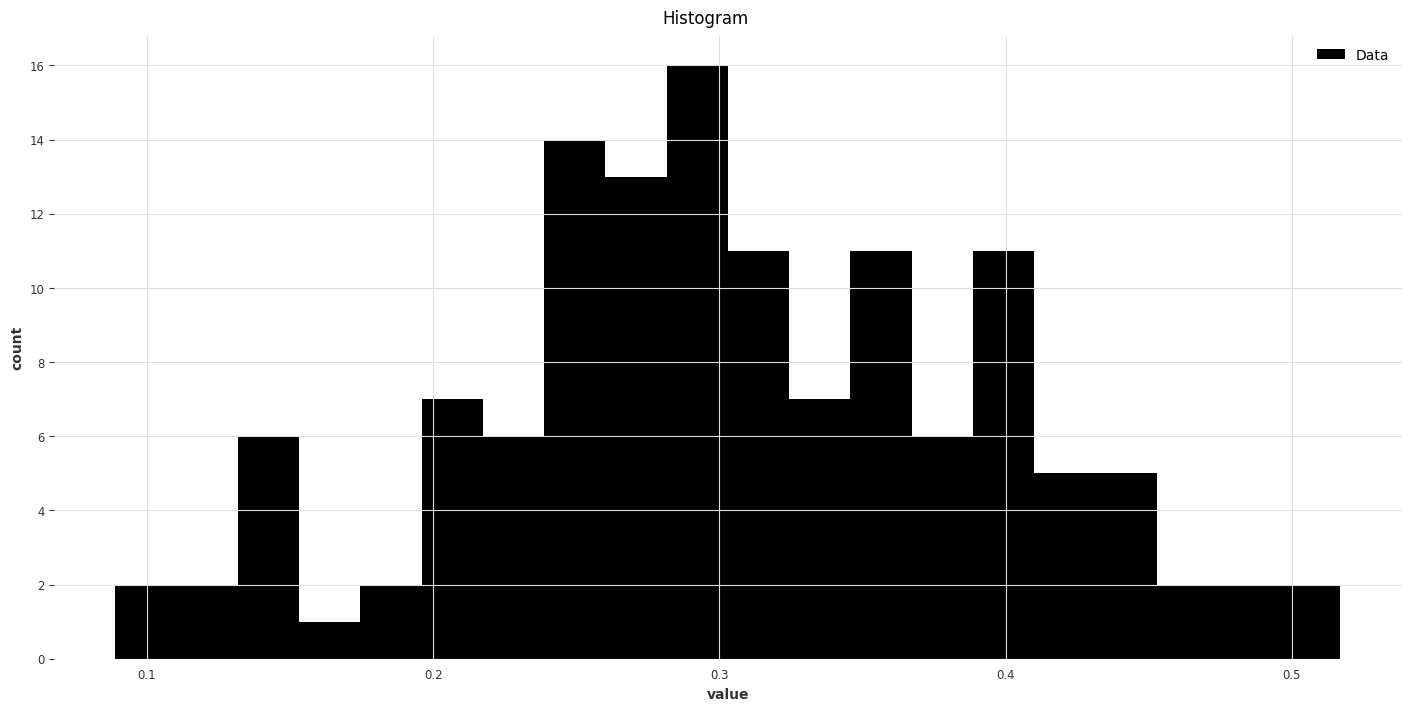

In [235]:
from darts.utils.statistics import plot_hist

plot_hist(mae_scores, bins=20)

In [236]:
avg_score = nhits_best_model.backtest(metric=mae, 
                          reduction=np.mean, 
                          last_points_only=True, 
                          stride=1, 
                          start=len(d_zen_train_sc),
                          series=d_zen_train_val_sc, 
                          past_covariates=d_cov_train_val_sc,
                          forecast_horizon=30,
                          retrain=False)
avg_score

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


np.float32(0.30740514)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


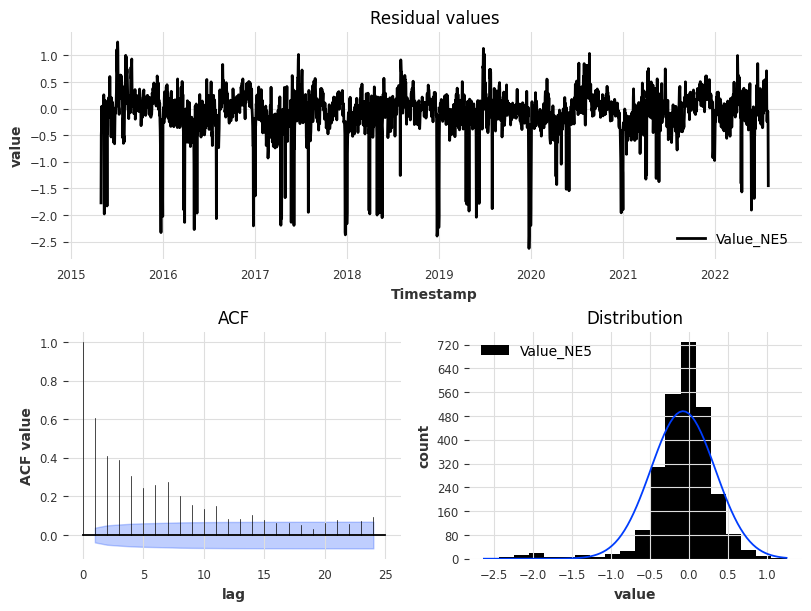

In [237]:
from darts.utils.statistics import plot_residuals_analysis
plot_residuals_analysis(
        nhits_best_model.residuals(
                            retrain=False, 
                            series=d_zen_train_val_sc, 
                            past_covariates=d_cov_train_val_sc))
